## Libraries and imports

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import pandas as pd
import tarfile
from tqdm import tqdm
import cv2
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import time
import matplotlib.patches as patches
from align import AlignDlib
from keras.models import model_from_json
from keras.models import load_model

## Databases

In [44]:
ATTRS_NAME = "../data/lfw_attributes.txt"

IMAGES_NAME = "../data/lfw-deepfunneled.tgz"

RAW_IMAGES_NAME = "../data/lfw.tgz"

## Image decoder

In [45]:
def decoder(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

## Image Loader

In [46]:
def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # Read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    df_attrs.head()
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # Read photos
    all_photos = []
    photo_ids = []


    # Read attrs
    #df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    #df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    #df_attrs.head()
    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in f.getmembers():
            # Only process image files from the compressed data
            print(m)
            if m.isfile() and m.name.endswith(".jpg"):
                # Prepare image
                img = decoder(f.extractfile(m).read())

                # Crop only faces and resize it
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))

                # Parse person and append it to the collected data
                foldername = os.path.split(m.name)
                filename = os.path.split(m.name)[-1]
                fname_splitted = filename[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'Person': person_id, 'imagenum': photo_number, 'Array': img, "File": filename, "Path": foldername })

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')

    # Preserve photo_ids order!
    #all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum'))

    return all_photos, photo_ids#all_attrs 

## Apply The Loader

In [47]:
X, photosDf = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)

<TarInfo 'lfw' at 0x7fc998f221f0>
<TarInfo 'lfw/George_HW_Bush' at 0x7fc998f222c0>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0001.jpg' at 0x7fc998f22120>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0002.jpg' at 0x7fc998f22390>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0003.jpg' at 0x7fc998f22460>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0004.jpg' at 0x7fc998f22600>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0005.jpg' at 0x7fc998f226d0>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0006.jpg' at 0x7fc998f227a0>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0007.jpg' at 0x7fc998f22870>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0008.jpg' at 0x7fc998f22940>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0009.jpg' at 0x7fc998f22a10>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0010.jpg' at 0x7fc998f22ae0>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0011.jpg' at 0x7fc998f22bb0>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0012.jpg' at 0x7fc998f22c80>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bu

<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0062.jpg' at 0x7fc9957dbef0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0063.jpg' at 0x7fc9957db050>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0064.jpg' at 0x7fc9957de120>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0065.jpg' at 0x7fc9957de1f0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0066.jpg' at 0x7fc9957de2c0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0067.jpg' at 0x7fc9957de390>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0068.jpg' at 0x7fc9957de460>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0069.jpg' at 0x7fc9957de530>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0070.jpg' at 0x7fc9957de600>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0071.jpg' at 0x7fc9957de6d0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0072.jpg' at 0x7fc9957de7a0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0073.jpg' at 0x7fc9957de870>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_00

<TarInfo 'lfw/George_W_Bush/George_W_Bush_0050.jpg' at 0x7fc9957976d0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0051.jpg' at 0x7fc9957977a0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0052.jpg' at 0x7fc995797870>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0053.jpg' at 0x7fc995797940>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0054.jpg' at 0x7fc995797a10>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0055.jpg' at 0x7fc995797ae0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0056.jpg' at 0x7fc995797bb0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0057.jpg' at 0x7fc995797c80>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0058.jpg' at 0x7fc995797d50>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0059.jpg' at 0x7fc995797e20>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0060.jpg' at 0x7fc995797ef0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0061.jpg' at 0x7fc995797050>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0062.jpg' at 0x7fc99579c050>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0063.jpg' at 0x7fc99579c120>
<TarIn

<TarInfo 'lfw/George_W_Bush/George_W_Bush_0280.jpg' at 0x7fc99574b870>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0281.jpg' at 0x7fc99574b940>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0282.jpg' at 0x7fc99574ba10>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0283.jpg' at 0x7fc99574bae0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0284.jpg' at 0x7fc99574bbb0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0285.jpg' at 0x7fc99574bc80>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0286.jpg' at 0x7fc99574bd50>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0287.jpg' at 0x7fc99574be20>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0288.jpg' at 0x7fc99574bef0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0289.jpg' at 0x7fc99574b050>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0290.jpg' at 0x7fc995750050>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0291.jpg' at 0x7fc9957501f0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0292.jpg' at 0x7fc9957502c0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0293.jpg' at 0x7fc995750390>
<TarIn

<TarInfo 'lfw/George_W_Bush/George_W_Bush_0518.jpg' at 0x7fc995702120>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0519.jpg' at 0x7fc9957021f0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0520.jpg' at 0x7fc9957022c0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0521.jpg' at 0x7fc995702390>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0522.jpg' at 0x7fc995702460>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0523.jpg' at 0x7fc995702530>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0524.jpg' at 0x7fc995702600>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0525.jpg' at 0x7fc9957026d0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0526.jpg' at 0x7fc9957027a0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0527.jpg' at 0x7fc995702870>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0528.jpg' at 0x7fc995702940>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0529.jpg' at 0x7fc995702a10>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0530.jpg' at 0x7fc995702ae0>
<TarInfo 'lfw/Ciro_Gomes' at 0x7fc995702bb0>
<TarInfo 'lfw/Ciro_Gomes/Ciro_Go

<TarInfo 'lfw/Kate_Winslet/Kate_Winslet_0002.jpg' at 0x7fc9956bf120>
<TarInfo 'lfw/Kate_Winslet/Kate_Winslet_0003.jpg' at 0x7fc9956bf530>
<TarInfo 'lfw/Kate_Winslet/Kate_Winslet_0004.jpg' at 0x7fc9956bf600>
<TarInfo 'lfw/James_Kelly' at 0x7fc9956bf6d0>
<TarInfo 'lfw/James_Kelly/James_Kelly_0001.jpg' at 0x7fc9956bf7a0>
<TarInfo 'lfw/James_Kelly/James_Kelly_0002.jpg' at 0x7fc9956bf460>
<TarInfo 'lfw/James_Kelly/James_Kelly_0003.jpg' at 0x7fc9956bf940>
<TarInfo 'lfw/James_Kelly/James_Kelly_0004.jpg' at 0x7fc9956bfa10>
<TarInfo 'lfw/James_Kelly/James_Kelly_0005.jpg' at 0x7fc9956bfae0>
<TarInfo 'lfw/James_Kelly/James_Kelly_0006.jpg' at 0x7fc9956bfbb0>
<TarInfo 'lfw/James_Kelly/James_Kelly_0007.jpg' at 0x7fc9956bfc80>
<TarInfo 'lfw/James_Kelly/James_Kelly_0008.jpg' at 0x7fc9956bfd50>
<TarInfo 'lfw/James_Kelly/James_Kelly_0009.jpg' at 0x7fc9956bfe20>
<TarInfo 'lfw/James_Kelly/James_Kelly_0010.jpg' at 0x7fc9956bfef0>
<TarInfo 'lfw/James_Kelly/James_Kelly_0011.jpg' at 0x7fc9956bf870>
<TarInfo '

<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0051.jpg' at 0x7fc99567c940>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0052.jpg' at 0x7fc99567ca10>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0053.jpg' at 0x7fc99567cae0>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0054.jpg' at 0x7fc99567cbb0>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0055.jpg' at 0x7fc99567cc80>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0056.jpg' at 0x7fc99567cd50>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0057.jpg' at 0x7fc99567ce20>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0058.jpg' at 0x7fc99567cef0>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0059.jpg' at 0x7fc99567c050>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0060.jpg' at 0x7fc99567e120>
<TarInfo 'lfw/Mathias_Reichhold' at 0x7fc99567e1f0>
<TarInfo 'lfw/Mathias_Reichhold/Mathias_Reichhold_0001.jpg' at 0x7fc99567e2c0>
<TarInfo 'lfw/Mathias_Reichhold/Mathias_Reichhold_0002.jpg' at 0x7fc99567e050>


<TarInfo 'lfw/Sergio_Vieira_De_Mello/Sergio_Vieira_De_Mello_0010.jpg' at 0x7fc995637870>
<TarInfo 'lfw/Sergio_Vieira_De_Mello/Sergio_Vieira_De_Mello_0011.jpg' at 0x7fc995637940>
<TarInfo 'lfw/James_Gandolfini' at 0x7fc995637a10>
<TarInfo 'lfw/James_Gandolfini/James_Gandolfini_0001.jpg' at 0x7fc995637ae0>
<TarInfo 'lfw/James_Gandolfini/James_Gandolfini_0002.jpg' at 0x7fc9956371f0>
<TarInfo 'lfw/James_Gandolfini/James_Gandolfini_0003.jpg' at 0x7fc995637c80>
<TarInfo 'lfw/Hamid_Karzai' at 0x7fc995637d50>
<TarInfo 'lfw/Hamid_Karzai/Hamid_Karzai_0001.jpg' at 0x7fc995637e20>
<TarInfo 'lfw/Hamid_Karzai/Hamid_Karzai_0002.jpg' at 0x7fc995637bb0>
<TarInfo 'lfw/Hamid_Karzai/Hamid_Karzai_0003.jpg' at 0x7fc995637ef0>
<TarInfo 'lfw/Hamid_Karzai/Hamid_Karzai_0004.jpg' at 0x7fc99563b120>
<TarInfo 'lfw/Hamid_Karzai/Hamid_Karzai_0005.jpg' at 0x7fc99563b1f0>
<TarInfo 'lfw/Hamid_Karzai/Hamid_Karzai_0006.jpg' at 0x7fc99563b2c0>
<TarInfo 'lfw/Hamid_Karzai/Hamid_Karzai_0007.jpg' at 0x7fc99563b390>
<TarInfo '

<TarInfo 'lfw/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0005.jpg' at 0x7fc9955f46d0>
<TarInfo 'lfw/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0006.jpg' at 0x7fc9955f47a0>
<TarInfo 'lfw/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0007.jpg' at 0x7fc9955f4870>
<TarInfo 'lfw/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0008.jpg' at 0x7fc9955f4940>
<TarInfo 'lfw/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0009.jpg' at 0x7fc9955f4a10>
<TarInfo 'lfw/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0010.jpg' at 0x7fc9955f4ae0>
<TarInfo 'lfw/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0011.jpg' at 0x7fc9955f4bb0>
<TarInfo 'lfw/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0012.jpg' at 0x7fc9955f4c80>
<TarInfo 'lfw/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0013.jpg' at 0x7fc9955f4d50>
<TarInfo 'lfw/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0014.jpg' at 0x7fc9955f4e20>
<TarInfo 'lfw/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0015.jpg' at 0x7fc9955f4ef0>
<TarInfo 'lfw/Megawati_Sukarnoputri/Megawat

<TarInfo 'lfw/Colin_Powell/Colin_Powell_0057.jpg' at 0x7fc9955abc80>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0058.jpg' at 0x7fc9955abd50>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0059.jpg' at 0x7fc9955abe20>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0060.jpg' at 0x7fc9955abef0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0061.jpg' at 0x7fc9955ab050>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0062.jpg' at 0x7fc9955ae120>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0063.jpg' at 0x7fc9955ae1f0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0064.jpg' at 0x7fc9955ae2c0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0065.jpg' at 0x7fc9955ae390>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0066.jpg' at 0x7fc9955ae460>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0067.jpg' at 0x7fc9955ae530>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0068.jpg' at 0x7fc9955ae600>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0069.jpg' at 0x7fc9955ae6d0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0070.jpg' at 0x7fc9955ae7a0>
<TarInfo 'lfw/Colin_Powell/Colin_P

<TarInfo 'lfw/Daniel_Rouse' at 0x7fc9955de7a0>
<TarInfo 'lfw/Daniel_Rouse/Daniel_Rouse_0001.jpg' at 0x7fc9955de870>
<TarInfo 'lfw/Tonga' at 0x7fc9955de050>
<TarInfo 'lfw/Tonga/Tonga_0001.jpg' at 0x7fc9955dea10>
<TarInfo 'lfw/Hans_Blix' at 0x7fc9955de940>
<TarInfo 'lfw/Hans_Blix/Hans_Blix_0001.jpg' at 0x7fc9955debb0>
<TarInfo 'lfw/Hans_Blix/Hans_Blix_0002.jpg' at 0x7fc9955deae0>
<TarInfo 'lfw/Hans_Blix/Hans_Blix_0003.jpg' at 0x7fc9955ded50>
<TarInfo 'lfw/Hans_Blix/Hans_Blix_0004.jpg' at 0x7fc9955dee20>
<TarInfo 'lfw/Hans_Blix/Hans_Blix_0005.jpg' at 0x7fc9955deef0>
<TarInfo 'lfw/Hans_Blix/Hans_Blix_0006.jpg' at 0x7fc9955dec80>
<TarInfo 'lfw/Hans_Blix/Hans_Blix_0007.jpg' at 0x7fc9955e4120>
<TarInfo 'lfw/Hans_Blix/Hans_Blix_0008.jpg' at 0x7fc9955e41f0>
<TarInfo 'lfw/Hans_Blix/Hans_Blix_0009.jpg' at 0x7fc9955e42c0>
<TarInfo 'lfw/Hans_Blix/Hans_Blix_0010.jpg' at 0x7fc9955e4390>
<TarInfo 'lfw/Hans_Blix/Hans_Blix_0011.jpg' at 0x7fc9955e4460>
<TarInfo 'lfw/Hans_Blix/Hans_Blix_0012.jpg' at 0x7fc

<TarInfo 'lfw/Andre_Agassi/Andre_Agassi_0005.jpg' at 0x7fc9955a0460>
<TarInfo 'lfw/Andre_Agassi/Andre_Agassi_0006.jpg' at 0x7fc9955a0530>
<TarInfo 'lfw/Andre_Agassi/Andre_Agassi_0007.jpg' at 0x7fc9955a0600>
<TarInfo 'lfw/Andre_Agassi/Andre_Agassi_0008.jpg' at 0x7fc9955a06d0>
<TarInfo 'lfw/Andre_Agassi/Andre_Agassi_0009.jpg' at 0x7fc9955a07a0>
<TarInfo 'lfw/Andre_Agassi/Andre_Agassi_0010.jpg' at 0x7fc9955a0870>
<TarInfo 'lfw/Andre_Agassi/Andre_Agassi_0011.jpg' at 0x7fc9955a0940>
<TarInfo 'lfw/Andre_Agassi/Andre_Agassi_0012.jpg' at 0x7fc9955a0a10>
<TarInfo 'lfw/Andre_Agassi/Andre_Agassi_0013.jpg' at 0x7fc9955a0ae0>
<TarInfo 'lfw/Andre_Agassi/Andre_Agassi_0014.jpg' at 0x7fc9955a0bb0>
<TarInfo 'lfw/Andre_Agassi/Andre_Agassi_0015.jpg' at 0x7fc9955a0c80>
<TarInfo 'lfw/Andre_Agassi/Andre_Agassi_0016.jpg' at 0x7fc9955a0d50>
<TarInfo 'lfw/Andre_Agassi/Andre_Agassi_0017.jpg' at 0x7fc9955a0e20>
<TarInfo 'lfw/Andre_Agassi/Andre_Agassi_0018.jpg' at 0x7fc9955a0ef0>
<TarInfo 'lfw/Andre_Agassi/Andre_A

<TarInfo 'lfw/Chan_Choi' at 0x7fc99555b7a0>
<TarInfo 'lfw/Chan_Choi/Chan_Choi_0001.jpg' at 0x7fc99555b940>
<TarInfo 'lfw/Myung_Yang' at 0x7fc99555b2c0>
<TarInfo 'lfw/Myung_Yang/Myung_Yang_0001.jpg' at 0x7fc99555bae0>
<TarInfo 'lfw/Eric_Daze' at 0x7fc99555ba10>
<TarInfo 'lfw/Eric_Daze/Eric_Daze_0001.jpg' at 0x7fc99555bc80>
<TarInfo 'lfw/Franz_Muentefering' at 0x7fc99555bbb0>
<TarInfo 'lfw/Franz_Muentefering/Franz_Muentefering_0001.jpg' at 0x7fc99555be20>
<TarInfo 'lfw/Franz_Muentefering/Franz_Muentefering_0002.jpg' at 0x7fc99555bd50>
<TarInfo 'lfw/Franz_Muentefering/Franz_Muentefering_0003.jpg' at 0x7fc99555bef0>
<TarInfo 'lfw/Franz_Muentefering/Franz_Muentefering_0004.jpg' at 0x7fc99555f120>
<TarInfo 'lfw/John_Ashcroft' at 0x7fc99555f1f0>
<TarInfo 'lfw/John_Ashcroft/John_Ashcroft_0001.jpg' at 0x7fc99555f2c0>
<TarInfo 'lfw/John_Ashcroft/John_Ashcroft_0002.jpg' at 0x7fc99555f050>
<TarInfo 'lfw/John_Ashcroft/John_Ashcroft_0003.jpg' at 0x7fc99555f460>
<TarInfo 'lfw/John_Ashcroft/John_Ashcr

<TarInfo 'lfw/Frank_Taylor' at 0x7fc99551b050>
<TarInfo 'lfw/Frank_Taylor/Frank_Taylor_0001.jpg' at 0x7fc99551b2c0>
<TarInfo 'lfw/Elin_Nordegren' at 0x7fc99551b1f0>
<TarInfo 'lfw/Elin_Nordegren/Elin_Nordegren_0001.jpg' at 0x7fc99551b460>
<TarInfo 'lfw/Elin_Nordegren/Elin_Nordegren_0002.jpg' at 0x7fc99551b390>
<TarInfo 'lfw/Karin_Stoiber' at 0x7fc99551b600>
<TarInfo 'lfw/Karin_Stoiber/Karin_Stoiber_0001.jpg' at 0x7fc99551b6d0>
<TarInfo 'lfw/Karin_Stoiber/Karin_Stoiber_0002.jpg' at 0x7fc99551b530>
<TarInfo 'lfw/Enrique_Bolanos' at 0x7fc99551b870>
<TarInfo 'lfw/Enrique_Bolanos/Enrique_Bolanos_0001.jpg' at 0x7fc99551b940>
<TarInfo 'lfw/Enrique_Bolanos/Enrique_Bolanos_0002.jpg' at 0x7fc99551b7a0>
<TarInfo 'lfw/Enrique_Bolanos/Enrique_Bolanos_0003.jpg' at 0x7fc99551bae0>
<TarInfo 'lfw/Enrique_Bolanos/Enrique_Bolanos_0004.jpg' at 0x7fc99551bbb0>
<TarInfo 'lfw/Enrique_Bolanos/Enrique_Bolanos_0005.jpg' at 0x7fc99551bc80>
<TarInfo 'lfw/Jeffrey_Donaldson' at 0x7fc99551bd50>
<TarInfo 'lfw/Jeffrey_

<TarInfo 'lfw/Steffi_Graf/Steffi_Graf_0003.jpg' at 0x7fc9954d8c80>
<TarInfo 'lfw/Steffi_Graf/Steffi_Graf_0004.jpg' at 0x7fc9954d8d50>
<TarInfo 'lfw/Steffi_Graf/Steffi_Graf_0005.jpg' at 0x7fc9954d8e20>
<TarInfo 'lfw/Johnny_Tapia' at 0x7fc9954d8ef0>
<TarInfo 'lfw/Johnny_Tapia/Johnny_Tapia_0001.jpg' at 0x7fc9954d8bb0>
<TarInfo 'lfw/Johnny_Tapia/Johnny_Tapia_0002.jpg' at 0x7fc9954dc050>
<TarInfo 'lfw/Johnny_Tapia/Johnny_Tapia_0003.jpg' at 0x7fc9954dc1f0>
<TarInfo 'lfw/Danny_Avalon' at 0x7fc9954dc2c0>
<TarInfo 'lfw/Danny_Avalon/Danny_Avalon_0001.jpg' at 0x7fc9954dc390>
<TarInfo 'lfw/Richard_Gephardt' at 0x7fc9954dc120>
<TarInfo 'lfw/Richard_Gephardt/Richard_Gephardt_0001.jpg' at 0x7fc9954dc530>
<TarInfo 'lfw/Richard_Gephardt/Richard_Gephardt_0002.jpg' at 0x7fc9954dc460>
<TarInfo 'lfw/Richard_Gephardt/Richard_Gephardt_0003.jpg' at 0x7fc9954dc6d0>
<TarInfo 'lfw/Richard_Gephardt/Richard_Gephardt_0004.jpg' at 0x7fc9954dc7a0>
<TarInfo 'lfw/Richard_Gephardt/Richard_Gephardt_0005.jpg' at 0x7fc9954

<TarInfo 'lfw/George_Papandreou/George_Papandreou_0004.jpg' at 0x7fc995494bb0>
<TarInfo 'lfw/Mesut_Yilmaz' at 0x7fc995494c80>
<TarInfo 'lfw/Mesut_Yilmaz/Mesut_Yilmaz_0001.jpg' at 0x7fc995494d50>
<TarInfo 'lfw/Mesut_Yilmaz/Mesut_Yilmaz_0002.jpg' at 0x7fc995494a10>
<TarInfo 'lfw/Marat_Safin' at 0x7fc995494ef0>
<TarInfo 'lfw/Marat_Safin/Marat_Safin_0001.jpg' at 0x7fc995494e20>
<TarInfo 'lfw/Marat_Safin/Marat_Safin_0002.jpg' at 0x7fc995499050>
<TarInfo 'lfw/Marat_Safin/Marat_Safin_0003.jpg' at 0x7fc9954991f0>
<TarInfo 'lfw/Gabrielle_Rose' at 0x7fc9954992c0>
<TarInfo 'lfw/Gabrielle_Rose/Gabrielle_Rose_0001.jpg' at 0x7fc995499390>
<TarInfo 'lfw/Tomoko_Hagiwara' at 0x7fc995499120>
<TarInfo 'lfw/Tomoko_Hagiwara/Tomoko_Hagiwara_0001.jpg' at 0x7fc995499530>
<TarInfo 'lfw/Tomoko_Hagiwara/Tomoko_Hagiwara_0002.jpg' at 0x7fc995499460>
<TarInfo 'lfw/John_Wayne' at 0x7fc9954996d0>
<TarInfo 'lfw/John_Wayne/John_Wayne_0001.jpg' at 0x7fc9954997a0>
<TarInfo 'lfw/Juan_Carlos_Ferrero' at 0x7fc995499600>
<Ta

<TarInfo 'lfw/Rudolph_Giuliani/Rudolph_Giuliani_0016.jpg' at 0x7fc99544fae0>
<TarInfo 'lfw/Rudolph_Giuliani/Rudolph_Giuliani_0017.jpg' at 0x7fc99544fbb0>
<TarInfo 'lfw/Rudolph_Giuliani/Rudolph_Giuliani_0018.jpg' at 0x7fc99544fc80>
<TarInfo 'lfw/Rudolph_Giuliani/Rudolph_Giuliani_0019.jpg' at 0x7fc99544fd50>
<TarInfo 'lfw/Rudolph_Giuliani/Rudolph_Giuliani_0020.jpg' at 0x7fc99544fe20>
<TarInfo 'lfw/Rudolph_Giuliani/Rudolph_Giuliani_0021.jpg' at 0x7fc99544fef0>
<TarInfo 'lfw/Rudolph_Giuliani/Rudolph_Giuliani_0022.jpg' at 0x7fc99544f050>
<TarInfo 'lfw/Rudolph_Giuliani/Rudolph_Giuliani_0023.jpg' at 0x7fc995454050>
<TarInfo 'lfw/Rudolph_Giuliani/Rudolph_Giuliani_0024.jpg' at 0x7fc9954541f0>
<TarInfo 'lfw/Rudolph_Giuliani/Rudolph_Giuliani_0025.jpg' at 0x7fc9954542c0>
<TarInfo 'lfw/Rudolph_Giuliani/Rudolph_Giuliani_0026.jpg' at 0x7fc995454390>
<TarInfo 'lfw/Abdullah_Ahmad_Badawi' at 0x7fc995454460>
<TarInfo 'lfw/Abdullah_Ahmad_Badawi/Abdullah_Ahmad_Badawi_0001.jpg' at 0x7fc995454530>
<TarInfo '

<TarInfo 'lfw/Peter_Holmberg' at 0x7fc995414870>
<TarInfo 'lfw/Peter_Holmberg/Peter_Holmberg_0001.jpg' at 0x7fc995414ae0>
<TarInfo 'lfw/Peter_Gilmour' at 0x7fc995414a10>
<TarInfo 'lfw/Peter_Gilmour/Peter_Gilmour_0001.jpg' at 0x7fc995414c80>
<TarInfo 'lfw/Nick_Rahall' at 0x7fc995414bb0>
<TarInfo 'lfw/Nick_Rahall/Nick_Rahall_0001.jpg' at 0x7fc995414e20>
<TarInfo 'lfw/Laurie_Laychak' at 0x7fc995414d50>
<TarInfo 'lfw/Laurie_Laychak/Laurie_Laychak_0001.jpg' at 0x7fc995414ef0>
<TarInfo 'lfw/Charlie_Williams' at 0x7fc995417050>
<TarInfo 'lfw/Charlie_Williams/Charlie_Williams_0001.jpg' at 0x7fc995417120>
<TarInfo 'lfw/Ishaq_Shahryar' at 0x7fc9954171f0>
<TarInfo 'lfw/Ishaq_Shahryar/Ishaq_Shahryar_0001.jpg' at 0x7fc995417390>
<TarInfo 'lfw/Ishaq_Shahryar/Ishaq_Shahryar_0002.jpg' at 0x7fc9954172c0>
<TarInfo 'lfw/Rose_Linkins' at 0x7fc995417530>
<TarInfo 'lfw/Rose_Linkins/Rose_Linkins_0001.jpg' at 0x7fc995417600>
<TarInfo 'lfw/Lee_Ann_Womack' at 0x7fc995417460>
<TarInfo 'lfw/Lee_Ann_Womack/Lee_Ann

<TarInfo 'lfw/Hugo_Chavez/Hugo_Chavez_0070.jpg' at 0x7fc9953d4e20>
<TarInfo 'lfw/Hugo_Chavez/Hugo_Chavez_0071.jpg' at 0x7fc9953d4ef0>
<TarInfo 'lfw/Ali_Ahmeti' at 0x7fc9953d4050>
<TarInfo 'lfw/Ali_Ahmeti/Ali_Ahmeti_0001.jpg' at 0x7fc9953d8050>
<TarInfo 'lfw/Asif_Ali_Zardari' at 0x7fc9953d8120>
<TarInfo 'lfw/Asif_Ali_Zardari/Asif_Ali_Zardari_0001.jpg' at 0x7fc9953d82c0>
<TarInfo 'lfw/Raul_Cubas' at 0x7fc9953d81f0>
<TarInfo 'lfw/Raul_Cubas/Raul_Cubas_0001.jpg' at 0x7fc9953d8460>
<TarInfo 'lfw/Darin_Erstad' at 0x7fc9953d8390>
<TarInfo 'lfw/Darin_Erstad/Darin_Erstad_0001.jpg' at 0x7fc9953d8600>
<TarInfo 'lfw/Paul_McCartney' at 0x7fc9953d8530>
<TarInfo 'lfw/Paul_McCartney/Paul_McCartney_0001.jpg' at 0x7fc9953d87a0>
<TarInfo 'lfw/Paul_McCartney/Paul_McCartney_0002.jpg' at 0x7fc9953d86d0>
<TarInfo 'lfw/Paul_McCartney/Paul_McCartney_0003.jpg' at 0x7fc9953d8940>
<TarInfo 'lfw/Paul_McCartney/Paul_McCartney_0004.jpg' at 0x7fc9953d8a10>
<TarInfo 'lfw/Paul_McCartney/Paul_McCartney_0005.jpg' at 0x7f

<TarInfo 'lfw/Tommy_Franks/Tommy_Franks_0008.jpg' at 0x7fc99539c2c0>
<TarInfo 'lfw/Tommy_Franks/Tommy_Franks_0009.jpg' at 0x7fc99539c390>
<TarInfo 'lfw/Tommy_Franks/Tommy_Franks_0010.jpg' at 0x7fc99539c460>
<TarInfo 'lfw/Tommy_Franks/Tommy_Franks_0011.jpg' at 0x7fc99539c530>
<TarInfo 'lfw/Tommy_Franks/Tommy_Franks_0012.jpg' at 0x7fc99539c600>
<TarInfo 'lfw/Tommy_Franks/Tommy_Franks_0013.jpg' at 0x7fc99539c6d0>
<TarInfo 'lfw/Tommy_Franks/Tommy_Franks_0014.jpg' at 0x7fc99539c7a0>
<TarInfo 'lfw/Tommy_Franks/Tommy_Franks_0015.jpg' at 0x7fc99539c870>
<TarInfo 'lfw/Tommy_Franks/Tommy_Franks_0016.jpg' at 0x7fc99539c940>
<TarInfo 'lfw/Abdullah_al-Attiyah' at 0x7fc99539ca10>
<TarInfo 'lfw/Abdullah_al-Attiyah/Abdullah_al-Attiyah_0001.jpg' at 0x7fc99539cae0>
<TarInfo 'lfw/Abdullah_al-Attiyah/Abdullah_al-Attiyah_0002.jpg' at 0x7fc99539c120>
<TarInfo 'lfw/Abdullah_al-Attiyah/Abdullah_al-Attiyah_0003.jpg' at 0x7fc99539cc80>
<TarInfo 'lfw/Karen_Pereiras' at 0x7fc99539cd50>
<TarInfo 'lfw/Karen_Pereira

<TarInfo 'lfw/Michael_Douglas' at 0x7fc99535bef0>
<TarInfo 'lfw/Michael_Douglas/Michael_Douglas_0001.jpg' at 0x7fc995361120>
<TarInfo 'lfw/Michael_Douglas/Michael_Douglas_0002.jpg' at 0x7fc995361050>
<TarInfo 'lfw/Michael_Douglas/Michael_Douglas_0003.jpg' at 0x7fc9953612c0>
<TarInfo 'lfw/Michael_Douglas/Michael_Douglas_0004.jpg' at 0x7fc995361390>
<TarInfo 'lfw/Michael_Douglas/Michael_Douglas_0005.jpg' at 0x7fc995361460>
<TarInfo 'lfw/Michael_Douglas/Michael_Douglas_0006.jpg' at 0x7fc995361530>
<TarInfo 'lfw/Brian_De_Palma' at 0x7fc995361600>
<TarInfo 'lfw/Brian_De_Palma/Brian_De_Palma_0001.jpg' at 0x7fc9953616d0>
<TarInfo 'lfw/Nanni_Moretti' at 0x7fc9953611f0>
<TarInfo 'lfw/Nanni_Moretti/Nanni_Moretti_0001.jpg' at 0x7fc995361870>
<TarInfo 'lfw/Nanni_Moretti/Nanni_Moretti_0002.jpg' at 0x7fc9953617a0>
<TarInfo 'lfw/Stefan_Holm' at 0x7fc995361a10>
<TarInfo 'lfw/Stefan_Holm/Stefan_Holm_0001.jpg' at 0x7fc995361ae0>
<TarInfo 'lfw/Mark_Mulder' at 0x7fc995361940>
<TarInfo 'lfw/Mark_Mulder/Mar

<TarInfo 'lfw/Pamela_Anderson/Pamela_Anderson_0002.jpg' at 0x7fc99531c870>
<TarInfo 'lfw/Pamela_Anderson/Pamela_Anderson_0003.jpg' at 0x7fc99531cc80>
<TarInfo 'lfw/Pamela_Anderson/Pamela_Anderson_0004.jpg' at 0x7fc99531cd50>
<TarInfo 'lfw/Pamela_Anderson/Pamela_Anderson_0005.jpg' at 0x7fc99531ce20>
<TarInfo 'lfw/Chris_Dodd' at 0x7fc99531cef0>
<TarInfo 'lfw/Chris_Dodd/Chris_Dodd_0001.jpg' at 0x7fc99531cbb0>
<TarInfo 'lfw/Aicha_El_Ouafi' at 0x7fc995321050>
<TarInfo 'lfw/Aicha_El_Ouafi/Aicha_El_Ouafi_0001.jpg' at 0x7fc9953211f0>
<TarInfo 'lfw/Aicha_El_Ouafi/Aicha_El_Ouafi_0002.jpg' at 0x7fc995321120>
<TarInfo 'lfw/Aicha_El_Ouafi/Aicha_El_Ouafi_0003.jpg' at 0x7fc995321390>
<TarInfo 'lfw/Cathy_Freeman' at 0x7fc995321460>
<TarInfo 'lfw/Cathy_Freeman/Cathy_Freeman_0001.jpg' at 0x7fc995321530>
<TarInfo 'lfw/Cathy_Freeman/Cathy_Freeman_0002.jpg' at 0x7fc9953212c0>
<TarInfo 'lfw/Juan_Antonio_Samaranch' at 0x7fc9953216d0>
<TarInfo 'lfw/Juan_Antonio_Samaranch/Juan_Antonio_Samaranch_0001.jpg' at 0x

<TarInfo 'lfw/Jesse_Jackson/Jesse_Jackson_0003.jpg' at 0x7fc9952e0a10>
<TarInfo 'lfw/Jesse_Jackson/Jesse_Jackson_0004.jpg' at 0x7fc9952e0ae0>
<TarInfo 'lfw/Jesse_Jackson/Jesse_Jackson_0005.jpg' at 0x7fc9952e0bb0>
<TarInfo 'lfw/Jesse_Jackson/Jesse_Jackson_0006.jpg' at 0x7fc9952e0c80>
<TarInfo 'lfw/Jesse_Jackson/Jesse_Jackson_0007.jpg' at 0x7fc9952e0d50>
<TarInfo 'lfw/Jesse_Jackson/Jesse_Jackson_0008.jpg' at 0x7fc9952e0e20>
<TarInfo 'lfw/Jesse_Jackson/Jesse_Jackson_0009.jpg' at 0x7fc9952e0ef0>
<TarInfo 'lfw/Jean-Francois_Lemounier' at 0x7fc9952e0940>
<TarInfo 'lfw/Jean-Francois_Lemounier/Jean-Francois_Lemounier_0001.jpg' at 0x7fc9952e5120>
<TarInfo 'lfw/Laurent_Jalabert' at 0x7fc9952e5050>
<TarInfo 'lfw/Laurent_Jalabert/Laurent_Jalabert_0001.jpg' at 0x7fc9952e52c0>
<TarInfo 'lfw/Laurent_Jalabert/Laurent_Jalabert_0002.jpg' at 0x7fc9952e51f0>
<TarInfo 'lfw/Mark_Schweiker' at 0x7fc9952e5460>
<TarInfo 'lfw/Mark_Schweiker/Mark_Schweiker_0001.jpg' at 0x7fc9952e5530>
<TarInfo 'lfw/Mark_Schweike

<TarInfo 'lfw/Howard_Dean/Howard_Dean_0003.jpg' at 0x7fc995229390>
<TarInfo 'lfw/Howard_Dean/Howard_Dean_0004.jpg' at 0x7fc995229460>
<TarInfo 'lfw/Howard_Dean/Howard_Dean_0005.jpg' at 0x7fc995229530>
<TarInfo 'lfw/Howard_Dean/Howard_Dean_0006.jpg' at 0x7fc995229600>
<TarInfo 'lfw/Howard_Dean/Howard_Dean_0007.jpg' at 0x7fc9952296d0>
<TarInfo 'lfw/Howard_Dean/Howard_Dean_0008.jpg' at 0x7fc9952297a0>
<TarInfo 'lfw/Howard_Dean/Howard_Dean_0009.jpg' at 0x7fc995229870>
<TarInfo 'lfw/Howard_Dean/Howard_Dean_0010.jpg' at 0x7fc9952292c0>
<TarInfo 'lfw/Howard_Dean/Howard_Dean_0011.jpg' at 0x7fc995229ae0>
<TarInfo 'lfw/Howard_Dean/Howard_Dean_0012.jpg' at 0x7fc995229940>
<TarInfo 'lfw/Ernie_Els' at 0x7fc995229bb0>
<TarInfo 'lfw/Ernie_Els/Ernie_Els_0001.jpg' at 0x7fc995229c80>
<TarInfo 'lfw/Ernie_Els/Ernie_Els_0002.jpg' at 0x7fc995229a10>
<TarInfo 'lfw/Ernie_Els/Ernie_Els_0003.jpg' at 0x7fc995229e20>
<TarInfo 'lfw/Ernie_Els/Ernie_Els_0004.jpg' at 0x7fc995229ef0>
<TarInfo 'lfw/Meghann_Shaughnessy'

<TarInfo 'lfw/Clifford_Robinson' at 0x7fc995265ae0>
<TarInfo 'lfw/Clifford_Robinson/Clifford_Robinson_0001.jpg' at 0x7fc995265d50>
<TarInfo 'lfw/Tayshaun_Prince' at 0x7fc995265c80>
<TarInfo 'lfw/Tayshaun_Prince/Tayshaun_Prince_0001.jpg' at 0x7fc995265ef0>
<TarInfo 'lfw/Mehmet_Okur' at 0x7fc995265e20>
<TarInfo 'lfw/Mehmet_Okur/Mehmet_Okur_0001.jpg' at 0x7fc9951e9120>
<TarInfo 'lfw/Corliss_Williamson' at 0x7fc9951e9050>
<TarInfo 'lfw/Corliss_Williamson/Corliss_Williamson_0001.jpg' at 0x7fc9951e92c0>
<TarInfo 'lfw/Ben_Wallace' at 0x7fc9951e91f0>
<TarInfo 'lfw/Ben_Wallace/Ben_Wallace_0001.jpg' at 0x7fc9951e9460>
<TarInfo 'lfw/Albrecht_Mentz' at 0x7fc9951e9390>
<TarInfo 'lfw/Albrecht_Mentz/Albrecht_Mentz_0001.jpg' at 0x7fc9951e9600>
<TarInfo 'lfw/Albrecht_Mentz/Albrecht_Mentz_0002.jpg' at 0x7fc9951e9530>
<TarInfo 'lfw/Jimmy_Gurule' at 0x7fc9951e97a0>
<TarInfo 'lfw/Jimmy_Gurule/Jimmy_Gurule_0001.jpg' at 0x7fc9951e9870>
<TarInfo 'lfw/Estelle_Morris' at 0x7fc9951e96d0>
<TarInfo 'lfw/Estelle_Mo

<TarInfo 'lfw/Carlos_Menem/Carlos_Menem_0004.jpg' at 0x7fc9951ae6d0>
<TarInfo 'lfw/Carlos_Menem/Carlos_Menem_0005.jpg' at 0x7fc9951ae7a0>
<TarInfo 'lfw/Carlos_Menem/Carlos_Menem_0006.jpg' at 0x7fc9951ae870>
<TarInfo 'lfw/Carlos_Menem/Carlos_Menem_0007.jpg' at 0x7fc9951ae940>
<TarInfo 'lfw/Carlos_Menem/Carlos_Menem_0008.jpg' at 0x7fc9951aea10>
<TarInfo 'lfw/Carlos_Menem/Carlos_Menem_0009.jpg' at 0x7fc9951aeae0>
<TarInfo 'lfw/Carlos_Menem/Carlos_Menem_0010.jpg' at 0x7fc9951aebb0>
<TarInfo 'lfw/Carlos_Menem/Carlos_Menem_0011.jpg' at 0x7fc9951aec80>
<TarInfo 'lfw/Carlos_Menem/Carlos_Menem_0012.jpg' at 0x7fc9951aed50>
<TarInfo 'lfw/Carlos_Menem/Carlos_Menem_0013.jpg' at 0x7fc9951aee20>
<TarInfo 'lfw/Carlos_Menem/Carlos_Menem_0014.jpg' at 0x7fc9951aeef0>
<TarInfo 'lfw/Carlos_Menem/Carlos_Menem_0015.jpg' at 0x7fc9951ae530>
<TarInfo 'lfw/Carlos_Menem/Carlos_Menem_0016.jpg' at 0x7fc9951b1050>
<TarInfo 'lfw/Carlos_Menem/Carlos_Menem_0017.jpg' at 0x7fc9951b11f0>
<TarInfo 'lfw/Carlos_Menem/Carlos_

<TarInfo 'lfw/Binyamin_Ben-Eliezer' at 0x7fc99516d7a0>
<TarInfo 'lfw/Binyamin_Ben-Eliezer/Binyamin_Ben-Eliezer_0001.jpg' at 0x7fc99516d870>
<TarInfo 'lfw/Binyamin_Ben-Eliezer/Binyamin_Ben-Eliezer_0002.jpg' at 0x7fc99516d530>
<TarInfo 'lfw/Binyamin_Ben-Eliezer/Binyamin_Ben-Eliezer_0003.jpg' at 0x7fc99516da10>
<TarInfo 'lfw/Binyamin_Ben-Eliezer/Binyamin_Ben-Eliezer_0004.jpg' at 0x7fc99516dae0>
<TarInfo 'lfw/Binyamin_Ben-Eliezer/Binyamin_Ben-Eliezer_0005.jpg' at 0x7fc99516dbb0>
<TarInfo 'lfw/Binyamin_Ben-Eliezer/Binyamin_Ben-Eliezer_0006.jpg' at 0x7fc99516dc80>
<TarInfo 'lfw/Binyamin_Ben-Eliezer/Binyamin_Ben-Eliezer_0007.jpg' at 0x7fc99516dd50>
<TarInfo 'lfw/John_Negroponte' at 0x7fc99516de20>
<TarInfo 'lfw/John_Negroponte/John_Negroponte_0001.jpg' at 0x7fc99516def0>
<TarInfo 'lfw/John_Negroponte/John_Negroponte_0002.jpg' at 0x7fc99516d940>
<TarInfo 'lfw/John_Negroponte/John_Negroponte_0003.jpg' at 0x7fc995170120>
<TarInfo 'lfw/John_Negroponte/John_Negroponte_0004.jpg' at 0x7fc9951701f0>


<TarInfo 'lfw/Shane_Warne' at 0x7fc9951322c0>
<TarInfo 'lfw/Shane_Warne/Shane_Warne_0001.jpg' at 0x7fc995132530>
<TarInfo 'lfw/Shane_Warne/Shane_Warne_0002.jpg' at 0x7fc995132460>
<TarInfo 'lfw/Hilda_Fortune' at 0x7fc9951326d0>
<TarInfo 'lfw/Hilda_Fortune/Hilda_Fortune_0001.jpg' at 0x7fc9951327a0>
<TarInfo 'lfw/Taufik_Hidayat' at 0x7fc995132600>
<TarInfo 'lfw/Taufik_Hidayat/Taufik_Hidayat_0001.jpg' at 0x7fc995132940>
<TarInfo 'lfw/Taufik_Hidayat/Taufik_Hidayat_0002.jpg' at 0x7fc995132870>
<TarInfo 'lfw/Taufik_Hidayat/Taufik_Hidayat_0003.jpg' at 0x7fc995132ae0>
<TarInfo 'lfw/Gorden_Tallis' at 0x7fc995132bb0>
<TarInfo 'lfw/Gorden_Tallis/Gorden_Tallis_0001.jpg' at 0x7fc995132c80>
<TarInfo 'lfw/Mike_Brey' at 0x7fc995132a10>
<TarInfo 'lfw/Mike_Brey/Mike_Brey_0001.jpg' at 0x7fc995132e20>
<TarInfo 'lfw/Mike_Brey/Mike_Brey_0002.jpg' at 0x7fc995132d50>
<TarInfo 'lfw/Dolma_Tsering' at 0x7fc995132ef0>
<TarInfo 'lfw/Dolma_Tsering/Dolma_Tsering_0001.jpg' at 0x7fc995135120>
<TarInfo 'lfw/Dolma_Tseri

<TarInfo 'lfw/Steven_Spielberg/Steven_Spielberg_0007.jpg' at 0x7fc9950f7c80>
<TarInfo 'lfw/Dave_Campo' at 0x7fc9950f7d50>
<TarInfo 'lfw/Dave_Campo/Dave_Campo_0001.jpg' at 0x7fc9950f7e20>
<TarInfo 'lfw/Dave_Campo/Dave_Campo_0002.jpg' at 0x7fc9950f7870>
<TarInfo 'lfw/Dave_Campo/Dave_Campo_0003.jpg' at 0x7fc9950f7ef0>
<TarInfo 'lfw/Max_Biaggi' at 0x7fc9950f9120>
<TarInfo 'lfw/Max_Biaggi/Max_Biaggi_0001.jpg' at 0x7fc9950f91f0>
<TarInfo 'lfw/Stephen_Ambrose' at 0x7fc9950f9050>
<TarInfo 'lfw/Stephen_Ambrose/Stephen_Ambrose_0001.jpg' at 0x7fc9950f9390>
<TarInfo 'lfw/Stephen_Ambrose/Stephen_Ambrose_0002.jpg' at 0x7fc9950f92c0>
<TarInfo 'lfw/Susilo_Bambang_Yudhoyono' at 0x7fc9950f9530>
<TarInfo 'lfw/Susilo_Bambang_Yudhoyono/Susilo_Bambang_Yudhoyono_0001.jpg' at 0x7fc9950f9600>
<TarInfo 'lfw/Susilo_Bambang_Yudhoyono/Susilo_Bambang_Yudhoyono_0002.jpg' at 0x7fc9950f9460>
<TarInfo 'lfw/Susilo_Bambang_Yudhoyono/Susilo_Bambang_Yudhoyono_0003.jpg' at 0x7fc9950f97a0>
<TarInfo 'lfw/Susilo_Bambang_Yudhoy

<TarInfo 'lfw/Jong_Thae_Hwa' at 0x7fc9950c1a10>
<TarInfo 'lfw/Jong_Thae_Hwa/Jong_Thae_Hwa_0001.jpg' at 0x7fc9950c1d50>
<TarInfo 'lfw/Jong_Thae_Hwa/Jong_Thae_Hwa_0002.jpg' at 0x7fc9950c1c80>
<TarInfo 'lfw/Jeff_George' at 0x7fc9950c1ef0>
<TarInfo 'lfw/Jeff_George/Jeff_George_0001.jpg' at 0x7fc9950c1e20>
<TarInfo 'lfw/Micah_Knorr' at 0x7fc9950c6050>
<TarInfo 'lfw/Micah_Knorr/Micah_Knorr_0001.jpg' at 0x7fc9950c61f0>
<TarInfo 'lfw/Grace_Dodd' at 0x7fc9950c6120>
<TarInfo 'lfw/Grace_Dodd/Grace_Dodd_0001.jpg' at 0x7fc9950c6390>
<TarInfo 'lfw/Ruben_Wolkowyski' at 0x7fc9950c62c0>
<TarInfo 'lfw/Ruben_Wolkowyski/Ruben_Wolkowyski_0001.jpg' at 0x7fc9950c6530>
<TarInfo 'lfw/David_Shayler' at 0x7fc9950c6460>
<TarInfo 'lfw/David_Shayler/David_Shayler_0001.jpg' at 0x7fc9950c66d0>
<TarInfo 'lfw/Norm_Coleman' at 0x7fc9950c6600>
<TarInfo 'lfw/Norm_Coleman/Norm_Coleman_0001.jpg' at 0x7fc9950c6870>
<TarInfo 'lfw/Norm_Coleman/Norm_Coleman_0002.jpg' at 0x7fc9950c67a0>
<TarInfo 'lfw/Norm_Coleman/Norm_Coleman_00

<TarInfo 'lfw/Frank_Cassell/Frank_Cassell_0002.jpg' at 0x7fc99508eae0>
<TarInfo 'lfw/Frank_Cassell/Frank_Cassell_0003.jpg' at 0x7fc99508ed50>
<TarInfo 'lfw/James_Brosnahan' at 0x7fc99508ee20>
<TarInfo 'lfw/James_Brosnahan/James_Brosnahan_0001.jpg' at 0x7fc99508eef0>
<TarInfo 'lfw/Elias_Attallah' at 0x7fc99508ec80>
<TarInfo 'lfw/Elias_Attallah/Elias_Attallah_0001.jpg' at 0x7fc995092050>
<TarInfo 'lfw/Alexander_Downer' at 0x7fc995092120>
<TarInfo 'lfw/Alexander_Downer/Alexander_Downer_0001.jpg' at 0x7fc9950922c0>
<TarInfo 'lfw/Alexander_Downer/Alexander_Downer_0002.jpg' at 0x7fc9950921f0>
<TarInfo 'lfw/Alexander_Downer/Alexander_Downer_0003.jpg' at 0x7fc995092460>
<TarInfo 'lfw/Alexander_Downer/Alexander_Downer_0004.jpg' at 0x7fc995092530>
<TarInfo 'lfw/Michael_Piuze' at 0x7fc995092600>
<TarInfo 'lfw/Michael_Piuze/Michael_Piuze_0001.jpg' at 0x7fc9950926d0>
<TarInfo 'lfw/Amanda_Coetzer' at 0x7fc995092390>
<TarInfo 'lfw/Amanda_Coetzer/Amanda_Coetzer_0001.jpg' at 0x7fc995092870>
<TarInfo 'l

<TarInfo 'lfw/Jose_Maria_Aznar/Jose_Maria_Aznar_0005.jpg' at 0x7fc9950561f0>
<TarInfo 'lfw/Jose_Maria_Aznar/Jose_Maria_Aznar_0006.jpg' at 0x7fc9950562c0>
<TarInfo 'lfw/Jose_Maria_Aznar/Jose_Maria_Aznar_0007.jpg' at 0x7fc995056390>
<TarInfo 'lfw/Jose_Maria_Aznar/Jose_Maria_Aznar_0008.jpg' at 0x7fc995056460>
<TarInfo 'lfw/Jose_Maria_Aznar/Jose_Maria_Aznar_0009.jpg' at 0x7fc995056530>
<TarInfo 'lfw/Jose_Maria_Aznar/Jose_Maria_Aznar_0010.jpg' at 0x7fc995056600>
<TarInfo 'lfw/Jose_Maria_Aznar/Jose_Maria_Aznar_0011.jpg' at 0x7fc9950566d0>
<TarInfo 'lfw/Jose_Maria_Aznar/Jose_Maria_Aznar_0012.jpg' at 0x7fc9950567a0>
<TarInfo 'lfw/Jose_Maria_Aznar/Jose_Maria_Aznar_0013.jpg' at 0x7fc995056870>
<TarInfo 'lfw/Jose_Maria_Aznar/Jose_Maria_Aznar_0014.jpg' at 0x7fc995056940>
<TarInfo 'lfw/Jose_Maria_Aznar/Jose_Maria_Aznar_0015.jpg' at 0x7fc995056a10>
<TarInfo 'lfw/Jose_Maria_Aznar/Jose_Maria_Aznar_0016.jpg' at 0x7fc995056ae0>
<TarInfo 'lfw/Jose_Maria_Aznar/Jose_Maria_Aznar_0017.jpg' at 0x7fc995056bb0>

<TarInfo 'lfw/Mike_Helton/Mike_Helton_0002.jpg' at 0x7fc995017050>
<TarInfo 'lfw/Paul_Vathis' at 0x7fc995017940>
<TarInfo 'lfw/Paul_Vathis/Paul_Vathis_0001.jpg' at 0x7fc995017a10>
<TarInfo 'lfw/Charles_Pickering' at 0x7fc995017870>
<TarInfo 'lfw/Charles_Pickering/Charles_Pickering_0001.jpg' at 0x7fc995017bb0>
<TarInfo 'lfw/Robert_Bullock' at 0x7fc995017ae0>
<TarInfo 'lfw/Robert_Bullock/Robert_Bullock_0001.jpg' at 0x7fc995017d50>
<TarInfo 'lfw/Robert_Bullock/Robert_Bullock_0002.jpg' at 0x7fc995017c80>
<TarInfo 'lfw/Walter_Woods' at 0x7fc995017ef0>
<TarInfo 'lfw/Walter_Woods/Walter_Woods_0001.jpg' at 0x7fc995017e20>
<TarInfo 'lfw/Marcus_Gronholm' at 0x7fc99501b050>
<TarInfo 'lfw/Marcus_Gronholm/Marcus_Gronholm_0001.jpg' at 0x7fc99501b1f0>
<TarInfo 'lfw/Marcus_Gronholm/Marcus_Gronholm_0002.jpg' at 0x7fc99501b120>
<TarInfo 'lfw/Mike_Weir' at 0x7fc99501b390>
<TarInfo 'lfw/Mike_Weir/Mike_Weir_0001.jpg' at 0x7fc99501b460>
<TarInfo 'lfw/Mike_Weir/Mike_Weir_0002.jpg' at 0x7fc99501b2c0>
<TarInfo

<TarInfo 'lfw/Terence_Newman' at 0x7fc994fe4050>
<TarInfo 'lfw/Terence_Newman/Terence_Newman_0001.jpg' at 0x7fc994fe42c0>
<TarInfo 'lfw/Sami_Al-Arian' at 0x7fc994fe41f0>
<TarInfo 'lfw/Sami_Al-Arian/Sami_Al-Arian_0001.jpg' at 0x7fc994fe4460>
<TarInfo 'lfw/Robert_McKee' at 0x7fc994fe4390>
<TarInfo 'lfw/Robert_McKee/Robert_McKee_0001.jpg' at 0x7fc994fe4600>
<TarInfo 'lfw/Mark_Mariscal' at 0x7fc994fe4530>
<TarInfo 'lfw/Mark_Mariscal/Mark_Mariscal_0001.jpg' at 0x7fc994fe47a0>
<TarInfo 'lfw/Charles_Chandler_IV' at 0x7fc994fe46d0>
<TarInfo 'lfw/Charles_Chandler_IV/Charles_Chandler_IV_0001.jpg' at 0x7fc994fe4940>
<TarInfo 'lfw/Tom_Reilly' at 0x7fc994fe4870>
<TarInfo 'lfw/Tom_Reilly/Tom_Reilly_0001.jpg' at 0x7fc994fe4ae0>
<TarInfo 'lfw/Tom_Reilly/Tom_Reilly_0002.jpg' at 0x7fc994fe4a10>
<TarInfo 'lfw/Tom_Reilly/Tom_Reilly_0003.jpg' at 0x7fc994fe4c80>
<TarInfo 'lfw/Joe_Friedberg' at 0x7fc994fe4d50>
<TarInfo 'lfw/Joe_Friedberg/Joe_Friedberg_0001.jpg' at 0x7fc994fe4e20>
<TarInfo 'lfw/Chuck_Bednarik

<TarInfo 'lfw/Miranda_Otto' at 0x7fc994f28ae0>
<TarInfo 'lfw/Miranda_Otto/Miranda_Otto_0001.jpg' at 0x7fc994f28d50>
<TarInfo 'lfw/James_Caan' at 0x7fc994f28c80>
<TarInfo 'lfw/James_Caan/James_Caan_0001.jpg' at 0x7fc994f28ef0>
<TarInfo 'lfw/James_Caan/James_Caan_0002.jpg' at 0x7fc994f28e20>
<TarInfo 'lfw/James_Caan/James_Caan_0003.jpg' at 0x7fc994f2b120>
<TarInfo 'lfw/Mary_Steenburgen' at 0x7fc994f2b1f0>
<TarInfo 'lfw/Mary_Steenburgen/Mary_Steenburgen_0001.jpg' at 0x7fc994f2b2c0>
<TarInfo 'lfw/Mary_Steenburgen/Mary_Steenburgen_0002.jpg' at 0x7fc994f2b050>
<TarInfo 'lfw/Mary_Steenburgen/Mary_Steenburgen_0003.jpg' at 0x7fc994f2b460>
<TarInfo 'lfw/Khatol_Mohammad_Zai' at 0x7fc994f2b530>
<TarInfo 'lfw/Khatol_Mohammad_Zai/Khatol_Mohammad_Zai_0001.jpg' at 0x7fc994f2b600>
<TarInfo 'lfw/Miguel_Aldana_Ibarra' at 0x7fc994f2b390>
<TarInfo 'lfw/Miguel_Aldana_Ibarra/Miguel_Aldana_Ibarra_0001.jpg' at 0x7fc994f2b7a0>
<TarInfo 'lfw/Gong_Li' at 0x7fc994f2b6d0>
<TarInfo 'lfw/Gong_Li/Gong_Li_0001.jpg' at 

<TarInfo 'lfw/Sheikh_Ahmed_Yassin' at 0x7fc994ef7120>
<TarInfo 'lfw/Sheikh_Ahmed_Yassin/Sheikh_Ahmed_Yassin_0001.jpg' at 0x7fc994ef71f0>
<TarInfo 'lfw/Dimitar_Berbatov' at 0x7fc994ef7050>
<TarInfo 'lfw/Dimitar_Berbatov/Dimitar_Berbatov_0001.jpg' at 0x7fc994ef7390>
<TarInfo 'lfw/Nelson_Shanks' at 0x7fc994ef72c0>
<TarInfo 'lfw/Nelson_Shanks/Nelson_Shanks_0001.jpg' at 0x7fc994ef7530>
<TarInfo 'lfw/Alexander_Rumyantsev' at 0x7fc994ef7460>
<TarInfo 'lfw/Alexander_Rumyantsev/Alexander_Rumyantsev_0001.jpg' at 0x7fc994ef76d0>
<TarInfo 'lfw/Alexander_Rumyantsev/Alexander_Rumyantsev_0002.jpg' at 0x7fc994ef7600>
<TarInfo 'lfw/Herb_Ritts' at 0x7fc994ef7870>
<TarInfo 'lfw/Herb_Ritts/Herb_Ritts_0001.jpg' at 0x7fc994ef7940>
<TarInfo 'lfw/Shawn_Marion' at 0x7fc994ef77a0>
<TarInfo 'lfw/Shawn_Marion/Shawn_Marion_0001.jpg' at 0x7fc994ef7ae0>
<TarInfo 'lfw/Walt_Harris' at 0x7fc994ef7a10>
<TarInfo 'lfw/Walt_Harris/Walt_Harris_0001.jpg' at 0x7fc994ef7c80>
<TarInfo 'lfw/Dennis_Erickson' at 0x7fc994ef7bb0>
<T

<TarInfo 'lfw/Linus_Roache' at 0x7fc994ec7050>
<TarInfo 'lfw/Linus_Roache/Linus_Roache_0001.jpg' at 0x7fc994ec71f0>
<TarInfo 'lfw/Stephen_Keener' at 0x7fc994ec7120>
<TarInfo 'lfw/Stephen_Keener/Stephen_Keener_0001.jpg' at 0x7fc994ec7390>
<TarInfo 'lfw/Daniel_Comisso_Urdaneta' at 0x7fc994ec72c0>
<TarInfo 'lfw/Daniel_Comisso_Urdaneta/Daniel_Comisso_Urdaneta_0001.jpg' at 0x7fc994ec7530>
<TarInfo 'lfw/Princess_Caroline' at 0x7fc994ec7460>
<TarInfo 'lfw/Princess_Caroline/Princess_Caroline_0001.jpg' at 0x7fc994ec76d0>
<TarInfo 'lfw/Princess_Caroline/Princess_Caroline_0002.jpg' at 0x7fc994ec7600>
<TarInfo 'lfw/Princess_Caroline/Princess_Caroline_0003.jpg' at 0x7fc994ec7870>
<TarInfo 'lfw/Princess_Caroline/Princess_Caroline_0004.jpg' at 0x7fc994ec7940>
<TarInfo 'lfw/Princess_Caroline/Princess_Caroline_0005.jpg' at 0x7fc994ec7a10>
<TarInfo 'lfw/Elton_John' at 0x7fc994ec7ae0>
<TarInfo 'lfw/Elton_John/Elton_John_0001.jpg' at 0x7fc994ec7bb0>
<TarInfo 'lfw/Elton_John/Elton_John_0002.jpg' at 0x7fc99

<TarInfo 'lfw/Steve_Cox' at 0x7fc994e94d50>
<TarInfo 'lfw/Steve_Cox/Steve_Cox_0001.jpg' at 0x7fc994e94ef0>
<TarInfo 'lfw/Wilson_Alvarez' at 0x7fc994e99050>
<TarInfo 'lfw/Wilson_Alvarez/Wilson_Alvarez_0001.jpg' at 0x7fc994e991f0>
<TarInfo 'lfw/Mariana_Ohata' at 0x7fc994e99120>
<TarInfo 'lfw/Mariana_Ohata/Mariana_Ohata_0001.jpg' at 0x7fc994e99390>
<TarInfo 'lfw/Carin_Koch' at 0x7fc994e992c0>
<TarInfo 'lfw/Carin_Koch/Carin_Koch_0001.jpg' at 0x7fc994e99530>
<TarInfo 'lfw/Michael_Chertoff' at 0x7fc994e99460>
<TarInfo 'lfw/Michael_Chertoff/Michael_Chertoff_0001.jpg' at 0x7fc994e996d0>
<TarInfo 'lfw/Rosie_Perez' at 0x7fc994e99600>
<TarInfo 'lfw/Rosie_Perez/Rosie_Perez_0001.jpg' at 0x7fc994e99870>
<TarInfo 'lfw/Scott_Verplank' at 0x7fc994e997a0>
<TarInfo 'lfw/Scott_Verplank/Scott_Verplank_0001.jpg' at 0x7fc994e99a10>
<TarInfo 'lfw/Helo_Pinheiro' at 0x7fc994e99940>
<TarInfo 'lfw/Helo_Pinheiro/Helo_Pinheiro_0001.jpg' at 0x7fc994e99bb0>
<TarInfo 'lfw/Peter_Fonda' at 0x7fc994e99ae0>
<TarInfo 'lfw/

<TarInfo 'lfw/Tim_Welsh' at 0x7fc994de9530>
<TarInfo 'lfw/Tim_Welsh/Tim_Welsh_0001.jpg' at 0x7fc994de97a0>
<TarInfo 'lfw/Shawn_Bradley' at 0x7fc994de96d0>
<TarInfo 'lfw/Shawn_Bradley/Shawn_Bradley_0001.jpg' at 0x7fc994de9940>
<TarInfo 'lfw/Greg_Frers' at 0x7fc994de9870>
<TarInfo 'lfw/Greg_Frers/Greg_Frers_0001.jpg' at 0x7fc994de9ae0>
<TarInfo 'lfw/Nicoletta_Braschi' at 0x7fc994de9a10>
<TarInfo 'lfw/Nicoletta_Braschi/Nicoletta_Braschi_0001.jpg' at 0x7fc994de9c80>
<TarInfo 'lfw/Colin_Phillips' at 0x7fc994de9bb0>
<TarInfo 'lfw/Colin_Phillips/Colin_Phillips_0001.jpg' at 0x7fc994de9e20>
<TarInfo 'lfw/Richard_Levin' at 0x7fc994de9d50>
<TarInfo 'lfw/Richard_Levin/Richard_Levin_0001.jpg' at 0x7fc994de9ef0>
<TarInfo 'lfw/Princess_Anne' at 0x7fc994dec050>
<TarInfo 'lfw/Princess_Anne/Princess_Anne_0001.jpg' at 0x7fc994dec1f0>
<TarInfo 'lfw/Princess_Anne/Princess_Anne_0002.jpg' at 0x7fc994dec120>
<TarInfo 'lfw/Princess_Hisako' at 0x7fc994dec390>
<TarInfo 'lfw/Princess_Hisako/Princess_Hisako_0001.j

<TarInfo 'lfw/Micheal_Jourdain_Jr' at 0x7fc994db57a0>
<TarInfo 'lfw/Micheal_Jourdain_Jr/Micheal_Jourdain_Jr_0001.jpg' at 0x7fc994db5870>
<TarInfo 'lfw/Mario_Dominguez' at 0x7fc994db5120>
<TarInfo 'lfw/Mario_Dominguez/Mario_Dominguez_0001.jpg' at 0x7fc994db5a10>
<TarInfo 'lfw/Adrian_Fernandez' at 0x7fc994db5940>
<TarInfo 'lfw/Adrian_Fernandez/Adrian_Fernandez_0001.jpg' at 0x7fc994db5bb0>
<TarInfo 'lfw/Erik_Morales' at 0x7fc994db5ae0>
<TarInfo 'lfw/Erik_Morales/Erik_Morales_0001.jpg' at 0x7fc994db5d50>
<TarInfo 'lfw/Erik_Morales/Erik_Morales_0002.jpg' at 0x7fc994db5c80>
<TarInfo 'lfw/Erik_Morales/Erik_Morales_0003.jpg' at 0x7fc994db5ef0>
<TarInfo 'lfw/Paulie_Ayala' at 0x7fc994db5e20>
<TarInfo 'lfw/Paulie_Ayala/Paulie_Ayala_0001.jpg' at 0x7fc994db9120>
<TarInfo 'lfw/Rupert_Grint' at 0x7fc994db9050>
<TarInfo 'lfw/Rupert_Grint/Rupert_Grint_0001.jpg' at 0x7fc994db92c0>
<TarInfo 'lfw/Rupert_Grint/Rupert_Grint_0002.jpg' at 0x7fc994db91f0>
<TarInfo 'lfw/Rupert_Grint/Rupert_Grint_0003.jpg' at 0x

<TarInfo 'lfw/Bill_Graham/Bill_Graham_0006.jpg' at 0x7fc994d872c0>
<TarInfo 'lfw/Bill_Graham/Bill_Graham_0007.jpg' at 0x7fc994d87390>
<TarInfo 'lfw/Bill_Graham/Bill_Graham_0008.jpg' at 0x7fc994d87460>
<TarInfo 'lfw/Bill_Graham/Bill_Graham_0009.jpg' at 0x7fc994d87530>
<TarInfo 'lfw/Gustavo_Noboa' at 0x7fc994d87600>
<TarInfo 'lfw/Gustavo_Noboa/Gustavo_Noboa_0001.jpg' at 0x7fc994d876d0>
<TarInfo 'lfw/Courtney_Cox' at 0x7fc994d87050>
<TarInfo 'lfw/Courtney_Cox/Courtney_Cox_0001.jpg' at 0x7fc994d87870>
<TarInfo 'lfw/Eileen_Coparropa' at 0x7fc994d877a0>
<TarInfo 'lfw/Eileen_Coparropa/Eileen_Coparropa_0001.jpg' at 0x7fc994d87a10>
<TarInfo 'lfw/Eileen_Coparropa/Eileen_Coparropa_0002.jpg' at 0x7fc994d87940>
<TarInfo 'lfw/Eileen_Coparropa/Eileen_Coparropa_0003.jpg' at 0x7fc994d87bb0>
<TarInfo 'lfw/Ximena_Bohorquez' at 0x7fc994d87c80>
<TarInfo 'lfw/Ximena_Bohorquez/Ximena_Bohorquez_0001.jpg' at 0x7fc994d87d50>
<TarInfo 'lfw/Chris_Simon' at 0x7fc994d87ae0>
<TarInfo 'lfw/Chris_Simon/Chris_Simon_000

<TarInfo 'lfw/Guillermo_Coria/Guillermo_Coria_0001.jpg' at 0x7fc994d52e20>
<TarInfo 'lfw/Guillermo_Coria/Guillermo_Coria_0002.jpg' at 0x7fc994d52c80>
<TarInfo 'lfw/Guillermo_Coria/Guillermo_Coria_0003.jpg' at 0x7fc994d52ef0>
<TarInfo 'lfw/Guillermo_Coria/Guillermo_Coria_0004.jpg' at 0x7fc994d55120>
<TarInfo 'lfw/Guillermo_Coria/Guillermo_Coria_0005.jpg' at 0x7fc994d551f0>
<TarInfo 'lfw/Guillermo_Coria/Guillermo_Coria_0006.jpg' at 0x7fc994d552c0>
<TarInfo 'lfw/Guillermo_Coria/Guillermo_Coria_0007.jpg' at 0x7fc994d55390>
<TarInfo 'lfw/Guillermo_Coria/Guillermo_Coria_0008.jpg' at 0x7fc994d55460>
<TarInfo 'lfw/Guillermo_Coria/Guillermo_Coria_0009.jpg' at 0x7fc994d55530>
<TarInfo 'lfw/Guillermo_Coria/Guillermo_Coria_0010.jpg' at 0x7fc994d55600>
<TarInfo 'lfw/Guillermo_Coria/Guillermo_Coria_0011.jpg' at 0x7fc994d556d0>
<TarInfo 'lfw/Guillermo_Coria/Guillermo_Coria_0012.jpg' at 0x7fc994d557a0>
<TarInfo 'lfw/Guillermo_Coria/Guillermo_Coria_0013.jpg' at 0x7fc994d55870>
<TarInfo 'lfw/Guillermo_C

<TarInfo 'lfw/Nestor_Kirchner/Nestor_Kirchner_0007.jpg' at 0x7fc994d1a390>
<TarInfo 'lfw/Nestor_Kirchner/Nestor_Kirchner_0008.jpg' at 0x7fc994d1a460>
<TarInfo 'lfw/Nestor_Kirchner/Nestor_Kirchner_0009.jpg' at 0x7fc994d1a530>
<TarInfo 'lfw/Nestor_Kirchner/Nestor_Kirchner_0010.jpg' at 0x7fc994d1a600>
<TarInfo 'lfw/Nestor_Kirchner/Nestor_Kirchner_0011.jpg' at 0x7fc994d1a6d0>
<TarInfo 'lfw/Nestor_Kirchner/Nestor_Kirchner_0012.jpg' at 0x7fc994d1a7a0>
<TarInfo 'lfw/Nestor_Kirchner/Nestor_Kirchner_0013.jpg' at 0x7fc994d1a870>
<TarInfo 'lfw/Nestor_Kirchner/Nestor_Kirchner_0014.jpg' at 0x7fc994d1a940>
<TarInfo 'lfw/Nestor_Kirchner/Nestor_Kirchner_0015.jpg' at 0x7fc994d1aa10>
<TarInfo 'lfw/Nestor_Kirchner/Nestor_Kirchner_0016.jpg' at 0x7fc994d1aae0>
<TarInfo 'lfw/Nestor_Kirchner/Nestor_Kirchner_0017.jpg' at 0x7fc994d1abb0>
<TarInfo 'lfw/Nestor_Kirchner/Nestor_Kirchner_0018.jpg' at 0x7fc994d1ac80>
<TarInfo 'lfw/Nestor_Kirchner/Nestor_Kirchner_0019.jpg' at 0x7fc994d1ad50>
<TarInfo 'lfw/Nestor_Kirc

<TarInfo 'lfw/Carlos_Salinas' at 0x7fc994cdd050>
<TarInfo 'lfw/Carlos_Salinas/Carlos_Salinas_0001.jpg' at 0x7fc994cdd530>
<TarInfo 'lfw/Ana_Paula_Gerard' at 0x7fc994cdd460>
<TarInfo 'lfw/Ana_Paula_Gerard/Ana_Paula_Gerard_0001.jpg' at 0x7fc994cdd6d0>
<TarInfo 'lfw/Carlos_Alberto' at 0x7fc994cdd600>
<TarInfo 'lfw/Carlos_Alberto/Carlos_Alberto_0001.jpg' at 0x7fc994cdd870>
<TarInfo 'lfw/Leander_Paes' at 0x7fc994cdd7a0>
<TarInfo 'lfw/Leander_Paes/Leander_Paes_0001.jpg' at 0x7fc994cdda10>
<TarInfo 'lfw/Leander_Paes/Leander_Paes_0002.jpg' at 0x7fc994cdd940>
<TarInfo 'lfw/Elaine_Stritch' at 0x7fc994cddbb0>
<TarInfo 'lfw/Elaine_Stritch/Elaine_Stritch_0001.jpg' at 0x7fc994cddc80>
<TarInfo 'lfw/Mark_Philippoussis' at 0x7fc994cddae0>
<TarInfo 'lfw/Mark_Philippoussis/Mark_Philippoussis_0001.jpg' at 0x7fc994cdde20>
<TarInfo 'lfw/Mark_Philippoussis/Mark_Philippoussis_0002.jpg' at 0x7fc994cddd50>
<TarInfo 'lfw/Mark_Philippoussis/Mark_Philippoussis_0003.jpg' at 0x7fc994cddef0>
<TarInfo 'lfw/Mark_Philip

<TarInfo 'lfw/Kathryn_Morris' at 0x7fc994c2d2c0>
<TarInfo 'lfw/Kathryn_Morris/Kathryn_Morris_0001.jpg' at 0x7fc994c2d530>
<TarInfo 'lfw/Rita_Grande' at 0x7fc994c2d460>
<TarInfo 'lfw/Rita_Grande/Rita_Grande_0001.jpg' at 0x7fc994c2d6d0>
<TarInfo 'lfw/Rita_Grande/Rita_Grande_0002.jpg' at 0x7fc994c2d600>
<TarInfo 'lfw/Rita_Grande/Rita_Grande_0003.jpg' at 0x7fc994c2d870>
<TarInfo 'lfw/Bob_Curtis' at 0x7fc994c2d940>
<TarInfo 'lfw/Bob_Curtis/Bob_Curtis_0001.jpg' at 0x7fc994c2da10>
<TarInfo 'lfw/Hannah_Stockbauer' at 0x7fc994c2d7a0>
<TarInfo 'lfw/Hannah_Stockbauer/Hannah_Stockbauer_0001.jpg' at 0x7fc994c2dbb0>
<TarInfo 'lfw/Hannah_Stockbauer/Hannah_Stockbauer_0002.jpg' at 0x7fc994c2dae0>
<TarInfo 'lfw/Chris_Penn' at 0x7fc994c2dd50>
<TarInfo 'lfw/Chris_Penn/Chris_Penn_0001.jpg' at 0x7fc994c2de20>
<TarInfo 'lfw/Francisco_Santos' at 0x7fc994c2dc80>
<TarInfo 'lfw/Francisco_Santos/Francisco_Santos_0001.jpg' at 0x7fc994c2def0>
<TarInfo 'lfw/Sananda_Maitreya' at 0x7fc994c32050>
<TarInfo 'lfw/Sananda_

<TarInfo 'lfw/Hiroki_Gomi' at 0x7fc994bfd390>
<TarInfo 'lfw/Hiroki_Gomi/Hiroki_Gomi_0001.jpg' at 0x7fc994bfd600>
<TarInfo 'lfw/Simon_Chalk' at 0x7fc994bfd530>
<TarInfo 'lfw/Simon_Chalk/Simon_Chalk_0001.jpg' at 0x7fc994bfd7a0>
<TarInfo 'lfw/Tom_DeLay' at 0x7fc994bfd6d0>
<TarInfo 'lfw/Tom_DeLay/Tom_DeLay_0001.jpg' at 0x7fc994bfd940>
<TarInfo 'lfw/Cheryl_Tiegs' at 0x7fc994bfd870>
<TarInfo 'lfw/Cheryl_Tiegs/Cheryl_Tiegs_0001.jpg' at 0x7fc994bfdae0>
<TarInfo 'lfw/Joseph_Estrada' at 0x7fc994bfda10>
<TarInfo 'lfw/Joseph_Estrada/Joseph_Estrada_0001.jpg' at 0x7fc994bfdc80>
<TarInfo 'lfw/Joseph_Estrada/Joseph_Estrada_0002.jpg' at 0x7fc994bfdbb0>
<TarInfo 'lfw/Joseph_Estrada/Joseph_Estrada_0003.jpg' at 0x7fc994bfde20>
<TarInfo 'lfw/Joseph_Estrada/Joseph_Estrada_0004.jpg' at 0x7fc994bfdef0>
<TarInfo 'lfw/Valentina_Tereshkova' at 0x7fc994bfdd50>
<TarInfo 'lfw/Valentina_Tereshkova/Valentina_Tereshkova_0001.jpg' at 0x7fc994c01050>
<TarInfo 'lfw/Suzanne_Mubarak' at 0x7fc994c01120>
<TarInfo 'lfw/Suzann

<TarInfo 'lfw/Bill_Stein' at 0x7fc994bcd1f0>
<TarInfo 'lfw/Bill_Stein/Bill_Stein_0001.jpg' at 0x7fc994bcd2c0>
<TarInfo 'lfw/Emilio_Azcarraga_Jean' at 0x7fc994bcd120>
<TarInfo 'lfw/Emilio_Azcarraga_Jean/Emilio_Azcarraga_Jean_0001.jpg' at 0x7fc994bcd460>
<TarInfo 'lfw/Scott_Fawell' at 0x7fc994bcd390>
<TarInfo 'lfw/Scott_Fawell/Scott_Fawell_0001.jpg' at 0x7fc994bcd600>
<TarInfo 'lfw/Carolina_Barco' at 0x7fc994bcd530>
<TarInfo 'lfw/Carolina_Barco/Carolina_Barco_0001.jpg' at 0x7fc994bcd7a0>
<TarInfo 'lfw/Brian_Griese' at 0x7fc994bcd6d0>
<TarInfo 'lfw/Brian_Griese/Brian_Griese_0001.jpg' at 0x7fc994bcd940>
<TarInfo 'lfw/Brian_Griese/Brian_Griese_0002.jpg' at 0x7fc994bcd870>
<TarInfo 'lfw/Tim_Floyd' at 0x7fc994bcdae0>
<TarInfo 'lfw/Tim_Floyd/Tim_Floyd_0001.jpg' at 0x7fc994bcdbb0>
<TarInfo 'lfw/Tim_Floyd/Tim_Floyd_0002.jpg' at 0x7fc994bcda10>
<TarInfo 'lfw/Chuck_Yeager' at 0x7fc994bcdd50>
<TarInfo 'lfw/Chuck_Yeager/Chuck_Yeager_0001.jpg' at 0x7fc994bcde20>
<TarInfo 'lfw/Chuck_Yeager/Chuck_Yeage

<TarInfo 'lfw/Roy_Moore/Roy_Moore_0002.jpg' at 0x7fc994ba1530>
<TarInfo 'lfw/Roy_Moore/Roy_Moore_0003.jpg' at 0x7fc994ba17a0>
<TarInfo 'lfw/Roy_Moore/Roy_Moore_0004.jpg' at 0x7fc994ba1870>
<TarInfo 'lfw/Roy_Moore/Roy_Moore_0005.jpg' at 0x7fc994ba1940>
<TarInfo 'lfw/Roy_Moore/Roy_Moore_0006.jpg' at 0x7fc994ba1a10>
<TarInfo 'lfw/Alex_Holmes' at 0x7fc994ba1ae0>
<TarInfo 'lfw/Alex_Holmes/Alex_Holmes_0001.jpg' at 0x7fc994ba1bb0>
<TarInfo 'lfw/Juan_Roman_Riquelme' at 0x7fc994ba16d0>
<TarInfo 'lfw/Juan_Roman_Riquelme/Juan_Roman_Riquelme_0001.jpg' at 0x7fc994ba1d50>
<TarInfo 'lfw/Giuseppe_Gibilisco' at 0x7fc994ba1c80>
<TarInfo 'lfw/Giuseppe_Gibilisco/Giuseppe_Gibilisco_0001.jpg' at 0x7fc994ba1ef0>
<TarInfo 'lfw/Giuseppe_Gibilisco/Giuseppe_Gibilisco_0002.jpg' at 0x7fc994ba1e20>
<TarInfo 'lfw/Giuseppe_Gibilisco/Giuseppe_Gibilisco_0003.jpg' at 0x7fc994b26050>
<TarInfo 'lfw/Giuseppe_Gibilisco/Giuseppe_Gibilisco_0004.jpg' at 0x7fc994b26120>
<TarInfo 'lfw/Platon_Lebedev' at 0x7fc994b262c0>
<TarInfo 

<TarInfo 'lfw/Robert_Hanssen' at 0x7fc994af6600>
<TarInfo 'lfw/Robert_Hanssen/Robert_Hanssen_0001.jpg' at 0x7fc994af6870>
<TarInfo 'lfw/Gloria_Allred' at 0x7fc994af67a0>
<TarInfo 'lfw/Gloria_Allred/Gloria_Allred_0001.jpg' at 0x7fc994af6a10>
<TarInfo 'lfw/Gloria_Allred/Gloria_Allred_0002.jpg' at 0x7fc994af6940>
<TarInfo 'lfw/Troy_Polamalu' at 0x7fc994af6bb0>
<TarInfo 'lfw/Troy_Polamalu/Troy_Polamalu_0001.jpg' at 0x7fc994af6c80>
<TarInfo 'lfw/Franklin_Brown' at 0x7fc994af6ae0>
<TarInfo 'lfw/Franklin_Brown/Franklin_Brown_0001.jpg' at 0x7fc994af6e20>
<TarInfo 'lfw/Lina_Krasnoroutskaya' at 0x7fc994af6d50>
<TarInfo 'lfw/Lina_Krasnoroutskaya/Lina_Krasnoroutskaya_0001.jpg' at 0x7fc994af6ef0>
<TarInfo 'lfw/Lina_Krasnoroutskaya/Lina_Krasnoroutskaya_0002.jpg' at 0x7fc994afb050>
<TarInfo 'lfw/Vadim_Devyatovskiy' at 0x7fc994afb1f0>
<TarInfo 'lfw/Vadim_Devyatovskiy/Vadim_Devyatovskiy_0001.jpg' at 0x7fc994afb2c0>
<TarInfo 'lfw/Jose_Canseco_Sr' at 0x7fc994afb120>
<TarInfo 'lfw/Jose_Canseco_Sr/Jose_Can

<TarInfo 'lfw/Olene_Walker' at 0x7fc994ace050>
<TarInfo 'lfw/Olene_Walker/Olene_Walker_0001.jpg' at 0x7fc994ace1f0>
<TarInfo 'lfw/Mark_Gangloff' at 0x7fc994ace120>
<TarInfo 'lfw/Mark_Gangloff/Mark_Gangloff_0001.jpg' at 0x7fc994ace390>
<TarInfo 'lfw/Nancy_Smith' at 0x7fc994ace2c0>
<TarInfo 'lfw/Nancy_Smith/Nancy_Smith_0001.jpg' at 0x7fc994ace530>
<TarInfo 'lfw/Ralph_Friedgen' at 0x7fc994ace460>
<TarInfo 'lfw/Ralph_Friedgen/Ralph_Friedgen_0001.jpg' at 0x7fc994ace6d0>
<TarInfo 'lfw/Chuck_Amato' at 0x7fc994ace600>
<TarInfo 'lfw/Chuck_Amato/Chuck_Amato_0001.jpg' at 0x7fc994ace870>
<TarInfo 'lfw/Chuck_Amato/Chuck_Amato_0002.jpg' at 0x7fc994ace7a0>
<TarInfo 'lfw/Raul_Chacon' at 0x7fc994acea10>
<TarInfo 'lfw/Raul_Chacon/Raul_Chacon_0001.jpg' at 0x7fc994aceae0>
<TarInfo 'lfw/Amy_Cotton' at 0x7fc994ace940>
<TarInfo 'lfw/Amy_Cotton/Amy_Cotton_0001.jpg' at 0x7fc994acec80>
<TarInfo 'lfw/Georgina_Bardach' at 0x7fc994acebb0>
<TarInfo 'lfw/Georgina_Bardach/Georgina_Bardach_0001.jpg' at 0x7fc994acee20>

<TarInfo 'lfw/Fiona_Milne' at 0x7fc994aa5530>
<TarInfo 'lfw/Fiona_Milne/Fiona_Milne_0001.jpg' at 0x7fc994aa57a0>
<TarInfo 'lfw/Craig_Wilson' at 0x7fc994aa56d0>
<TarInfo 'lfw/Craig_Wilson/Craig_Wilson_0001.jpg' at 0x7fc994aa5940>
<TarInfo 'lfw/Mike_Thibault' at 0x7fc994aa5870>
<TarInfo 'lfw/Mike_Thibault/Mike_Thibault_0001.jpg' at 0x7fc994aa5ae0>
<TarInfo 'lfw/Mathilda_Karel_Spak' at 0x7fc994aa5a10>
<TarInfo 'lfw/Mathilda_Karel_Spak/Mathilda_Karel_Spak_0001.jpg' at 0x7fc994aa5c80>
<TarInfo 'lfw/Ted_Christopher' at 0x7fc994aa5bb0>
<TarInfo 'lfw/Ted_Christopher/Ted_Christopher_0001.jpg' at 0x7fc994aa5e20>
<TarInfo 'lfw/Anthony_Pico' at 0x7fc994aa5d50>
<TarInfo 'lfw/Anthony_Pico/Anthony_Pico_0001.jpg' at 0x7fc994aa5ef0>
<TarInfo 'lfw/Rani_Mukherjee' at 0x7fc994a29050>
<TarInfo 'lfw/Rani_Mukherjee/Rani_Mukherjee_0001.jpg' at 0x7fc994a291f0>
<TarInfo 'lfw/Antonio_Bernardo' at 0x7fc994a29120>
<TarInfo 'lfw/Antonio_Bernardo/Antonio_Bernardo_0001.jpg' at 0x7fc994a29390>
<TarInfo 'lfw/Daryl_Smit

<TarInfo 'lfw/Stephane_Rochon' at 0x7fc9949f8940>
<TarInfo 'lfw/Stephane_Rochon/Stephane_Rochon_0001.jpg' at 0x7fc9949f8bb0>
<TarInfo 'lfw/Tom_Coverdale' at 0x7fc9949f8ae0>
<TarInfo 'lfw/Tom_Coverdale/Tom_Coverdale_0001.jpg' at 0x7fc9949f8d50>
<TarInfo 'lfw/Tom_Coverdale/Tom_Coverdale_0002.jpg' at 0x7fc9949f8c80>
<TarInfo 'lfw/Mark_Hamister' at 0x7fc9949f8ef0>
<TarInfo 'lfw/Mark_Hamister/Mark_Hamister_0001.jpg' at 0x7fc9949f8e20>
<TarInfo 'lfw/Mark_Hamister/Mark_Hamister_0002.jpg' at 0x7fc9949fc050>
<TarInfo 'lfw/Maria_Burks' at 0x7fc9949fc1f0>
<TarInfo 'lfw/Maria_Burks/Maria_Burks_0001.jpg' at 0x7fc9949fc2c0>
<TarInfo 'lfw/Derrick_Rodgers' at 0x7fc9949fc120>
<TarInfo 'lfw/Derrick_Rodgers/Derrick_Rodgers_0001.jpg' at 0x7fc9949fc460>
<TarInfo 'lfw/Jean-Pierre_Bemba' at 0x7fc9949fc390>
<TarInfo 'lfw/Jean-Pierre_Bemba/Jean-Pierre_Bemba_0001.jpg' at 0x7fc9949fc600>
<TarInfo 'lfw/Gwen_Stefani' at 0x7fc9949fc530>
<TarInfo 'lfw/Gwen_Stefani/Gwen_Stefani_0001.jpg' at 0x7fc9949fc7a0>
<TarInfo '

<TarInfo 'lfw/Edie_Falco' at 0x7fc9949c9390>
<TarInfo 'lfw/Edie_Falco/Edie_Falco_0001.jpg' at 0x7fc9949c96d0>
<TarInfo 'lfw/Edie_Falco/Edie_Falco_0002.jpg' at 0x7fc9949c9600>
<TarInfo 'lfw/George_Foreman' at 0x7fc9949c9870>
<TarInfo 'lfw/George_Foreman/George_Foreman_0001.jpg' at 0x7fc9949c9940>
<TarInfo 'lfw/George_Foreman/George_Foreman_0002.jpg' at 0x7fc9949c97a0>
<TarInfo 'lfw/Pete_Beaudrault' at 0x7fc9949c9ae0>
<TarInfo 'lfw/Pete_Beaudrault/Pete_Beaudrault_0001.jpg' at 0x7fc9949c9bb0>
<TarInfo 'lfw/Steven_Van_Zandt' at 0x7fc9949c9a10>
<TarInfo 'lfw/Steven_Van_Zandt/Steven_Van_Zandt_0001.jpg' at 0x7fc9949c9d50>
<TarInfo 'lfw/William_Overlin' at 0x7fc9949c9c80>
<TarInfo 'lfw/William_Overlin/William_Overlin_0001.jpg' at 0x7fc9949c9ef0>
<TarInfo 'lfw/Hussam_Mohammed_Amin' at 0x7fc9949c9e20>
<TarInfo 'lfw/Hussam_Mohammed_Amin/Hussam_Mohammed_Amin_0001.jpg' at 0x7fc9949cc050>
<TarInfo 'lfw/Rachel_Wheatley' at 0x7fc9949cc120>
<TarInfo 'lfw/Rachel_Wheatley/Rachel_Wheatley_0001.jpg' at 0x7

<TarInfo 'lfw/Jamie_Villafane/Jamie_Villafane_0002.jpg' at 0x7fc99499eae0>
<TarInfo 'lfw/Helmut_Panke' at 0x7fc99499ed50>
<TarInfo 'lfw/Helmut_Panke/Helmut_Panke_0001.jpg' at 0x7fc99499ee20>
<TarInfo 'lfw/Daniel_Patrick_Moynihan' at 0x7fc99499ec80>
<TarInfo 'lfw/Daniel_Patrick_Moynihan/Daniel_Patrick_Moynihan_0001.jpg' at 0x7fc99499eef0>
<TarInfo 'lfw/Roberto_Tovar' at 0x7fc9949a1050>
<TarInfo 'lfw/Roberto_Tovar/Roberto_Tovar_0001.jpg' at 0x7fc9949a11f0>
<TarInfo 'lfw/Vincent_Brooks' at 0x7fc9949a1120>
<TarInfo 'lfw/Vincent_Brooks/Vincent_Brooks_0001.jpg' at 0x7fc9949a1390>
<TarInfo 'lfw/Vincent_Brooks/Vincent_Brooks_0002.jpg' at 0x7fc9949a12c0>
<TarInfo 'lfw/Vincent_Brooks/Vincent_Brooks_0003.jpg' at 0x7fc9949a1530>
<TarInfo 'lfw/Vincent_Brooks/Vincent_Brooks_0004.jpg' at 0x7fc9949a1600>
<TarInfo 'lfw/Vincent_Brooks/Vincent_Brooks_0005.jpg' at 0x7fc9949a16d0>
<TarInfo 'lfw/Vincent_Brooks/Vincent_Brooks_0006.jpg' at 0x7fc9949a17a0>
<TarInfo 'lfw/Vincent_Brooks/Vincent_Brooks_0007.jpg' 

<TarInfo 'lfw/Rhett_Warrener' at 0x7fc9948f5530>
<TarInfo 'lfw/Rhett_Warrener/Rhett_Warrener_0001.jpg' at 0x7fc9948f5600>
<TarInfo 'lfw/Charles_Ingram' at 0x7fc9948f5460>
<TarInfo 'lfw/Charles_Ingram/Charles_Ingram_0001.jpg' at 0x7fc9948f57a0>
<TarInfo 'lfw/Jamie_Carey' at 0x7fc9948f56d0>
<TarInfo 'lfw/Jamie_Carey/Jamie_Carey_0001.jpg' at 0x7fc9948f5940>
<TarInfo 'lfw/Lisa_Stone' at 0x7fc9948f5870>
<TarInfo 'lfw/Lisa_Stone/Lisa_Stone_0001.jpg' at 0x7fc9948f5ae0>
<TarInfo 'lfw/Armand_Sargen' at 0x7fc9948f5a10>
<TarInfo 'lfw/Armand_Sargen/Armand_Sargen_0001.jpg' at 0x7fc9948f5c80>
<TarInfo 'lfw/Daniel_Coats' at 0x7fc9948f5bb0>
<TarInfo 'lfw/Daniel_Coats/Daniel_Coats_0001.jpg' at 0x7fc9948f5e20>
<TarInfo 'lfw/Brian_Scalabrine' at 0x7fc9948f5d50>
<TarInfo 'lfw/Brian_Scalabrine/Brian_Scalabrine_0001.jpg' at 0x7fc9948f5ef0>
<TarInfo 'lfw/Edouard_Michelin' at 0x7fc9948fa050>
<TarInfo 'lfw/Edouard_Michelin/Edouard_Michelin_0001.jpg' at 0x7fc9948fa1f0>
<TarInfo 'lfw/Bill_Guerin' at 0x7fc9948fa1

<TarInfo 'lfw/Roy_Rogers' at 0x7fc9948c6bb0>
<TarInfo 'lfw/Roy_Rogers/Roy_Rogers_0001.jpg' at 0x7fc9948c6e20>
<TarInfo 'lfw/Ari_Bousbib' at 0x7fc9948c6d50>
<TarInfo 'lfw/Ari_Bousbib/Ari_Bousbib_0001.jpg' at 0x7fc9948c6ef0>
<TarInfo 'lfw/Yoshiyuki_Kamei' at 0x7fc9948c9050>
<TarInfo 'lfw/Yoshiyuki_Kamei/Yoshiyuki_Kamei_0001.jpg' at 0x7fc9948c91f0>
<TarInfo 'lfw/Lutz_Freitag' at 0x7fc9948c9120>
<TarInfo 'lfw/Lutz_Freitag/Lutz_Freitag_0001.jpg' at 0x7fc9948c9390>
<TarInfo 'lfw/Danny_Morgan' at 0x7fc9948c92c0>
<TarInfo 'lfw/Danny_Morgan/Danny_Morgan_0001.jpg' at 0x7fc9948c9530>
<TarInfo 'lfw/Carlos_Juarez' at 0x7fc9948c9460>
<TarInfo 'lfw/Carlos_Juarez/Carlos_Juarez_0001.jpg' at 0x7fc9948c96d0>
<TarInfo 'lfw/Roger_Suarez' at 0x7fc9948c9600>
<TarInfo 'lfw/Roger_Suarez/Roger_Suarez_0001.jpg' at 0x7fc9948c9870>
<TarInfo 'lfw/Geraldo_Rivera' at 0x7fc9948c97a0>
<TarInfo 'lfw/Geraldo_Rivera/Geraldo_Rivera_0001.jpg' at 0x7fc9948c9a10>
<TarInfo 'lfw/Jennifer_Gratz' at 0x7fc9948c9940>
<TarInfo 'lfw/

<TarInfo 'lfw/Claudia_Schiffer/Claudia_Schiffer_0003.jpg' at 0x7fc99489e120>
<TarInfo 'lfw/Matthew_Vaughan' at 0x7fc99489e1f0>
<TarInfo 'lfw/Matthew_Vaughan/Matthew_Vaughan_0001.jpg' at 0x7fc99489e2c0>
<TarInfo 'lfw/Carrie-Anne_Moss' at 0x7fc99489e050>
<TarInfo 'lfw/Carrie-Anne_Moss/Carrie-Anne_Moss_0001.jpg' at 0x7fc99489e460>
<TarInfo 'lfw/Carrie-Anne_Moss/Carrie-Anne_Moss_0002.jpg' at 0x7fc99489e390>
<TarInfo 'lfw/Carrie-Anne_Moss/Carrie-Anne_Moss_0003.jpg' at 0x7fc99489e600>
<TarInfo 'lfw/Carrie-Anne_Moss/Carrie-Anne_Moss_0004.jpg' at 0x7fc99489e6d0>
<TarInfo 'lfw/Carrie-Anne_Moss/Carrie-Anne_Moss_0005.jpg' at 0x7fc99489e7a0>
<TarInfo 'lfw/Howard_Ross' at 0x7fc99489e870>
<TarInfo 'lfw/Howard_Ross/Howard_Ross_0001.jpg' at 0x7fc99489e940>
<TarInfo 'lfw/Chip_Ganassi' at 0x7fc99489e530>
<TarInfo 'lfw/Chip_Ganassi/Chip_Ganassi_0001.jpg' at 0x7fc99489eae0>
<TarInfo 'lfw/Billy_Donovan' at 0x7fc99489ea10>
<TarInfo 'lfw/Billy_Donovan/Billy_Donovan_0001.jpg' at 0x7fc99489ec80>
<TarInfo 'lfw/

<TarInfo 'lfw/Andrea_Kiser' at 0x7fc9947f67a0>
<TarInfo 'lfw/Andrea_Kiser/Andrea_Kiser_0001.jpg' at 0x7fc9947f6a10>
<TarInfo 'lfw/Nathalia_Gillot' at 0x7fc9947f6940>
<TarInfo 'lfw/Nathalia_Gillot/Nathalia_Gillot_0001.jpg' at 0x7fc9947f6bb0>
<TarInfo 'lfw/Colleen_Donovan' at 0x7fc9947f6ae0>
<TarInfo 'lfw/Colleen_Donovan/Colleen_Donovan_0001.jpg' at 0x7fc9947f6d50>
<TarInfo 'lfw/Sarah_Canale' at 0x7fc9947f6c80>
<TarInfo 'lfw/Sarah_Canale/Sarah_Canale_0001.jpg' at 0x7fc9947f6ef0>
<TarInfo 'lfw/Dan_Boyle' at 0x7fc9947f6e20>
<TarInfo 'lfw/Dan_Boyle/Dan_Boyle_0001.jpg' at 0x7fc9947fb050>
<TarInfo 'lfw/Chawki_Armali' at 0x7fc9947fb120>
<TarInfo 'lfw/Chawki_Armali/Chawki_Armali_0001.jpg' at 0x7fc9947fb2c0>
<TarInfo 'lfw/Roberto_Lavagna' at 0x7fc9947fb1f0>
<TarInfo 'lfw/Roberto_Lavagna/Roberto_Lavagna_0001.jpg' at 0x7fc9947fb460>
<TarInfo 'lfw/Roberto_Arguelles' at 0x7fc9947fb390>
<TarInfo 'lfw/Roberto_Arguelles/Roberto_Arguelles_0001.jpg' at 0x7fc9947fb600>
<TarInfo 'lfw/Teresa_Williams' at 0x

<TarInfo 'lfw/Flor_Montulo' at 0x7fc9947d0390>
<TarInfo 'lfw/Flor_Montulo/Flor_Montulo_0001.jpg' at 0x7fc9947d0460>
<TarInfo 'lfw/Flor_Montulo/Flor_Montulo_0002.jpg' at 0x7fc9947d02c0>
<TarInfo 'lfw/Jerry_Hall' at 0x7fc9947d0600>
<TarInfo 'lfw/Jerry_Hall/Jerry_Hall_0001.jpg' at 0x7fc9947d06d0>
<TarInfo 'lfw/Coleen_Rowley' at 0x7fc9947d0530>
<TarInfo 'lfw/Coleen_Rowley/Coleen_Rowley_0001.jpg' at 0x7fc9947d0870>
<TarInfo 'lfw/Sandra_Milo' at 0x7fc9947d07a0>
<TarInfo 'lfw/Sandra_Milo/Sandra_Milo_0001.jpg' at 0x7fc9947d0a10>
<TarInfo 'lfw/Chadha_Gurinder' at 0x7fc9947d0940>
<TarInfo 'lfw/Chadha_Gurinder/Chadha_Gurinder_0001.jpg' at 0x7fc9947d0bb0>
<TarInfo 'lfw/Filip_De_Winter' at 0x7fc9947d0ae0>
<TarInfo 'lfw/Filip_De_Winter/Filip_De_Winter_0001.jpg' at 0x7fc9947d0d50>
<TarInfo 'lfw/Dyab_Abou_Jahjah' at 0x7fc9947d0c80>
<TarInfo 'lfw/Dyab_Abou_Jahjah/Dyab_Abou_Jahjah_0001.jpg' at 0x7fc9947d0ef0>
<TarInfo 'lfw/Jose_Luis_Rodriguez_Zapatero' at 0x7fc9947d0e20>
<TarInfo 'lfw/Jose_Luis_Rodrigue

<TarInfo 'lfw/Gus_Van_Sant/Gus_Van_Sant_0002.jpg' at 0x7fc994726120>
<TarInfo 'lfw/Gus_Van_Sant/Gus_Van_Sant_0003.jpg' at 0x7fc9947262c0>
<TarInfo 'lfw/Werner_Schlager' at 0x7fc994726390>
<TarInfo 'lfw/Werner_Schlager/Werner_Schlager_0001.jpg' at 0x7fc994726460>
<TarInfo 'lfw/Nan_Wang' at 0x7fc9947261f0>
<TarInfo 'lfw/Nan_Wang/Nan_Wang_0001.jpg' at 0x7fc994726600>
<TarInfo 'lfw/Nan_Wang/Nan_Wang_0002.jpg' at 0x7fc994726530>
<TarInfo 'lfw/Nan_Wang/Nan_Wang_0003.jpg' at 0x7fc9947267a0>
<TarInfo 'lfw/Nan_Wang/Nan_Wang_0004.jpg' at 0x7fc994726870>
<TarInfo 'lfw/Helio_Castroneves' at 0x7fc994726940>
<TarInfo 'lfw/Helio_Castroneves/Helio_Castroneves_0001.jpg' at 0x7fc994726a10>
<TarInfo 'lfw/Peter_Greenaway' at 0x7fc9947266d0>
<TarInfo 'lfw/Peter_Greenaway/Peter_Greenaway_0001.jpg' at 0x7fc994726bb0>
<TarInfo 'lfw/Peter_Greenaway/Peter_Greenaway_0002.jpg' at 0x7fc994726ae0>
<TarInfo 'lfw/Eva_Amurri' at 0x7fc994726d50>
<TarInfo 'lfw/Eva_Amurri/Eva_Amurri_0001.jpg' at 0x7fc994726e20>
<TarInfo 

In [6]:
photosDf.head()

,Person,imagenum,Array,File,Path
0,George HW Bush,1,"[[[147, 126, 107], [126, 113, 91], [103, 97, 7...",George_HW_Bush_0001.jpg,"(lfw/George_HW_Bush, George_HW_Bush_0001.jpg)"
1,George HW Bush,3,"[[[175, 99, 37], [187, 113, 49], [203, 138, 78...",George_HW_Bush_0003.jpg,"(lfw/George_HW_Bush, George_HW_Bush_0003.jpg)"
2,George HW Bush,4,"[[[178, 180, 143], [174, 174, 137], [168, 168,...",George_HW_Bush_0004.jpg,"(lfw/George_HW_Bush, George_HW_Bush_0004.jpg)"
3,George HW Bush,5,"[[[155, 132, 118], [168, 135, 111], [181, 144,...",George_HW_Bush_0005.jpg,"(lfw/George_HW_Bush, George_HW_Bush_0005.jpg)"
4,George HW Bush,6,"[[[93, 137, 103], [79, 124, 83], [138, 185, 13...",George_HW_Bush_0006.jpg,"(lfw/George_HW_Bush, George_HW_Bush_0006.jpg)"


In [7]:
photosDf['Array'][0].shape

(32, 32, 3)

## Normalize

In [8]:
X = X.astype('float32') / 255.0 - 0.5

In [9]:
print(X.shape)

(13143, 32, 32, 3)


## Setup Training Model

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

## Autoencoder Function

In [11]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape)))
    decoder.add(Reshape(img_shape))

    return encoder, decoder

## Autoencoder Parameters

In [12]:
IMG_SHAPE = X.shape[1:]
encoder, decoder = build_autoencoder(IMG_SHAPE, 1000)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse', metrics=['accuracy'])

print(autoencoder.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1000)              3073000   
_________________________________________________________________
sequential_2 (Sequential)    (None, 32, 32, 3)         3075072   
Total params: 6,148,072
Trainable params: 6,148,072
Non-trainable params: 0
_________________________________________________________________
None


## Save the model after every epoch

In [13]:
filepath='Checkpoint_{epoch:02d}_{val_loss:.2f}'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

## Start the training

In [14]:
history = autoencoder.fit(x=X_train, y=X_train, epochs=5,
                validation_data=[X_test, X_test])

Train on 11828 samples, validate on 1315 samples
Epoch 1/5
11828/11828 [==============================] - 22s 2ms/step - loss: 0.0099 - accuracy: 0.9105 - val_loss: 0.0048 - val_accuracy: 0.9506
Epoch 2/5
11828/11828 [==============================] - 21s 2ms/step - loss: 0.0038 - accuracy: 0.9567 - val_loss: 0.0031 - val_accuracy: 0.9641
Epoch 3/5
11828/11828 [==============================] - 22s 2ms/step - loss: 0.0026 - accuracy: 0.9652 - val_loss: 0.0023 - val_accuracy: 0.9676
Epoch 4/5
11828/11828 [==============================] - 22s 2ms/step - loss: 0.0021 - accuracy: 0.9689 - val_loss: 0.0019 - val_accuracy: 0.9702
Epoch 5/5
11828/11828 [==============================] - 22s 2ms/step - loss: 0.0017 - accuracy: 0.9720 - val_loss: 0.0016 - val_accuracy: 0.9732


## Save and import the model

In [15]:
moment=time.localtime()
name='Model1{}.h5'.format(autoencoder.history.history["val_loss"][-1],moment[2],moment[3],moment[4])
autoencoder.save(name)

In [19]:
autoencoder.save("../data/models/autoencoder1_save", overwrite=True)
encoder.save("../data/models/encoder1_save", overwrite=True)
decoder.save("../data/models/decoder1_save", overwrite=True)

In [20]:
# serialize model to JSON
model_json = autoencoder.to_json()
with open("model1.json", "w") as json_file:
    json_file.write(model_json)

## Plotting the Model Loss

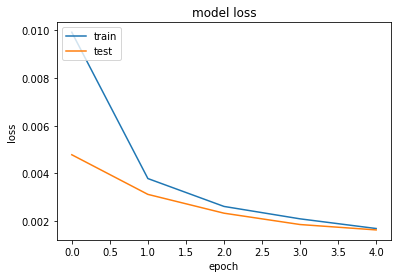

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('./graphics/model_loss.png')
plt.show()

## Function to Check Reconstructed Photos

In [22]:
import matplotlib.pyplot as plt
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

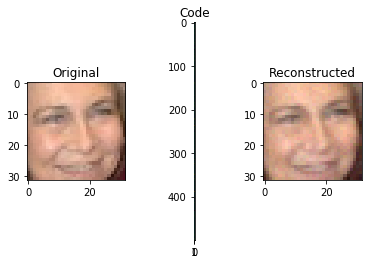

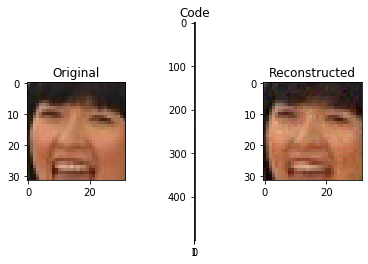

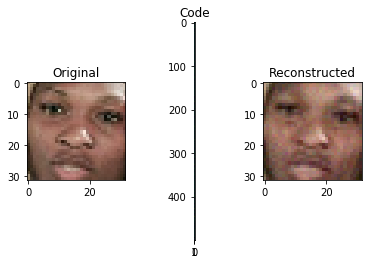

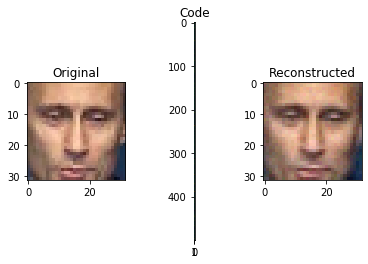

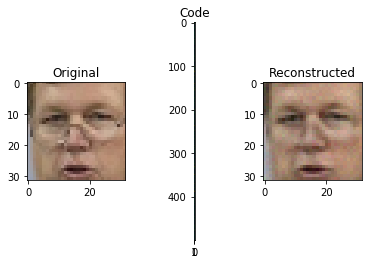

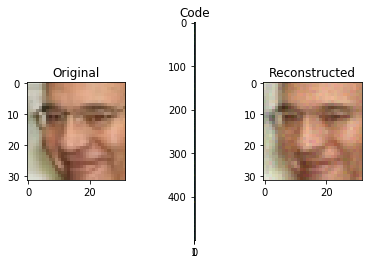

In [23]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    # img[None] will have shape of (1, 32, 32, 3) which is the same as the model input
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
   
    plt.show()
for i in range(6):
    img = X_test[i]
    visualize(img,encoder,decoder)

## Function to test the model with friends photos

In [24]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

In [28]:
def load_dataset(path):
    img_data_list=[]
    data_path = path

    data_dir_list = os.listdir(data_path)
    for dataset in data_dir_list:
        img_list=os.listdir(data_path+'/'+ dataset)
        print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
        for img in img_list:
            input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
            input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
            #input_img_resize=cv2.resize(input_img,(64,64))
            faces = face_cascade.detectMultiScale(input_img, 1.1, 3)
            print (faces[0])
            #input_img_resize=cv2.resize(input_img,(128,128))
            x,y,w,h = faces[0]
            print(x,y,w,h)
            face = input_img[y:y+h,x:x+w]
            face=cv2.resize(face,(32,32))
            #face = np.expand_dims(faces, axis=1)
            img_data_list.append(face)

    img_data = np.stack(img_data_list).astype('uint8')
    #img_data = img_data.astype('float32')
    return img_data

In [29]:
X = load_dataset("../data/fotop/")
X = X / 255.0 - 0.5
X.shape

Loaded the images of dataset-Clara

[172  62 141 141]
172 62 141 141
Loaded the images of dataset-Cris

[862 816 191 191]
862 816 191 191
Loaded the images of dataset-Cesar

[216 220 247 247]
216 220 247 247
Loaded the images of dataset-Julio

[ 44  25 102 102]
44 25 102 102
Loaded the images of dataset-Alex

[137 152 299 299]
137 152 299 299


(5, 32, 32, 3)

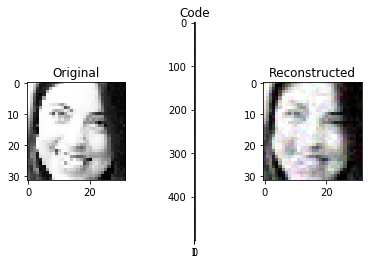

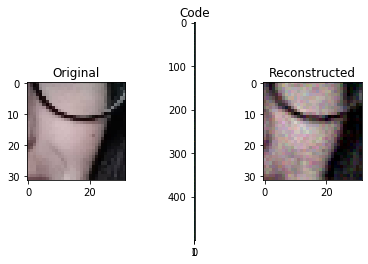

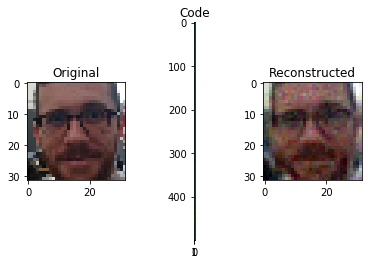

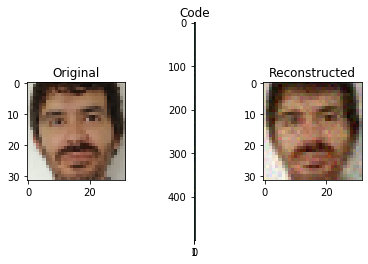

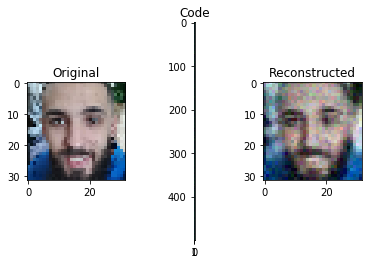

In [30]:
for i in range(5):
    img = X[i]
    visualize(img,encoder,decoder)

## Save and load to Json

In [37]:
json_file = open('model1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("Model10.001631113676400324.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(optimizer='adamax', loss='mse', metrics=['accuracy'])
score = loaded_model.evaluate(x=X_train, y=X_train, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 97.25%


## Save and load

In [40]:
# load model
model = load_model('Model10.001631113676400324.h5')
# summarize model.
model.summary()
# evaluate the model
score = model.evaluate(x=X_train, y=X_train, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1000)              3073000   
_________________________________________________________________
sequential_2 (Sequential)    (None, 32, 32, 3)         3075072   
Total params: 6,148,072
Trainable params: 6,148,072
Non-trainable params: 0
_________________________________________________________________
accuracy: 97.25%


In [42]:
X, photosDf = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)

<TarInfo 'lfw' at 0x7fc99e06fef0>
<TarInfo 'lfw/George_HW_Bush' at 0x7fc99e06f1f0>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0001.jpg' at 0x7fc999fee050>


ValueError: Layer sequential_2 was called with an input that isn't a symbolic tensor. Received type: <class 'bytes'>. Full input: [b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x03\x02\x02\x03\x02\x02\x03\x03\x03\x03\x04\x03\x03\x04\x05\x08\x05\x05\x04\x04\x05\n\x07\x07\x06\x08\x0c\n\x0c\x0c\x0b\n\x0b\x0b\r\x0e\x12\x10\r\x0e\x11\x0e\x0b\x0b\x10\x16\x10\x11\x13\x14\x15\x15\x15\x0c\x0f\x17\x18\x16\x14\x18\x12\x14\x15\x14\xff\xdb\x00C\x01\x03\x04\x04\x05\x04\x05\t\x05\x05\t\x14\r\x0b\r\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\xff\xc0\x00\x11\x08\x00\xfa\x00\xfa\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca\xd2\xd3\xd4\xd5\xd6\xd7\xd8\xd9\xda\xe1\xe2\xe3\xe4\xe5\xe6\xe7\xe8\xe9\xea\xf1\xf2\xf3\xf4\xf5\xf6\xf7\xf8\xf9\xfa\xff\xc4\x00\x1f\x01\x00\x03\x01\x01\x01\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x11\x00\x02\x01\x02\x04\x04\x03\x04\x07\x05\x04\x04\x00\x01\x02w\x00\x01\x02\x03\x11\x04\x05!1\x06\x12AQ\x07aq\x13"2\x81\x08\x14B\x91\xa1\xb1\xc1\t#3R\xf0\x15br\xd1\n\x16$4\xe1%\xf1\x17\x18\x19\x1a&\'()*56789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x82\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca\xd2\xd3\xd4\xd5\xd6\xd7\xd8\xd9\xda\xe2\xe3\xe4\xe5\xe6\xe7\xe8\xe9\xea\xf2\xf3\xf4\xf5\xf6\xf7\xf8\xf9\xfa\xff\xda\x00\x0c\x03\x01\x00\x02\x11\x03\x11\x00?\x00\xf9\x8d\x92\xa2\xdb\xf3V\x8d\xd3\xc5\x9d\xc8\x83\xe8*?+\xedCr\xa0\x8foa\xde\xbeh\xc7\x94\xab\xb2\x9a\xc9\xc5Z1\x102F*\x13*+`\xf3Q\xcc+\x10l\xf6\xa7*\xe2\xa4\xda\xa7\xe6\xcf\x1e\x94\xcd\xdb\x8e\x00\xfcj\xa2\xee\xc6\x95\xd8R\xac{\xf9\xf4\xa5\x8e&v\xabq\xdbH\xa3\x01r\x0fzU*(\xe89Y;\x14\xf1\xb8\xed\x15$6RH\xe1\x11r\xe6\xacAm\'\xda\x82\x08s\x93\xd7\x15\xd8[i\xa7L\xb4i\xda\x00\xceW\xe5b9\x06\xb0\xe7E\xc57\xb2\x1f\xe1\xaf\x07\xb3\xc6$\xbc\xf9V\xbd\x17\xc0\xbf\r\xad\xf5\xedr(,#3\x19\x18n"\xb9?\x0ch\xfa\xdf\x8c\xef-lm\xe4\x95C\xb6\x08\x1e\x99\xaf\xd0o\x80\x7f\x03l\xbe\x1ci0]]C\x1c\xb7\xf2\xa6r\xc3\x955\xbd*.n\xe6\xf5\xe9\xca\x84T\x99{\xe1\x8f\xc0\xad\x13\xc1\x1al\x17SC\xe7]2\x82c\xff\x00\xf5W\xaa\x062\xc4\x10\xae\xd8\x80\xc0\x03\x9c\n\xad{y\x1e\x91\x0b\xdc]\xc8\x11\xba\xa9\'\xa5y\xce\xad\xf1\xba\xca\xca\xe1\xedlS\xce\x94\xe7\xf3\xafb\x9c"\x95\xacJ\xa6\xe5\x15$z)\xb7\x8a\x17\xcd\xb8$\xff\x00\x17\x15a.#\x88pk\xc3\xa1\xf8\xb3\xac^\xdc\xce\x91\xc4b\xda\xac\xdd\xc6p3Z\x9e\x05\xf1\xd6\xa3\xac\xc9,\x93\xaa2\x81\x90\xacMt+ T\xe4\xba\x9e\xa1p\xef;\xe3\xf8M$V\xca\xa7&\xbcC\xc4\x1f\x18\xb5\r7T\x9e5x\xe3D=\x19\x88^\xb5\xabo\xf1\x90Y\xdb\x97\xbd\x05\xf7\x95\x00\xa7 f\x9d\xc2k\xb9\xecR]\xc7\x04\\\x1ezT6\xaee\x90\x91\\\xae\x95\xe2\xcb=wr\xa4\xf0\x82\xc7!\x03|\xe3\xf0\xae\xaa\xcc}\x92 ~\xf6\xee\x86\x8b\x998\x96dp\x87v\xd2\xc4t\xc5Th\xe2\x9aC,\x83kT\xce]p\xf9 7j\xcf\xd4nN@\x07\x14_K\x05\xb4#\xbe\x8a\xde\xea7\xb6\x9e3,r\x0c\x11\xed_\x16~\xd3\x1f\xb3\xd5\xc6\x8du.\xb3\xe1\xcbV\x9e)>iB\x83\xf2\xf7\xf7\xf5\xaf\xb4\xed\xaeP|\xcey\xe9\x93\xe9L\xbe\xb8\xb3\x9a\xce[g\n\xd0\xca0\xf1\x9e\x8d\xf5\xaeI\xd1R:(\xd4t\xf7?\x1c\xb5\x94\xfe\xcd\x9aX\xe6\x1b[8P}kS\xc0\x9e\x1cf\x90\xdf\xdc\x8ez\xaek\xea\x9f\xda\x8b\xf6s\xd2\xee3\xafi\x16\xf1Y\xdbDw\xbcp\x8c\x0e\xb9\xaf\x94\xf5\xff\x00\x88\x16\xba\x1d\x8f\x93n\xc0\x15\x1bF\xda\xf2\'A\xc2M\x9fC\x87\xab\xf5\x8bE#\xba\xd5|ug\xe1-.i%\x90\x0b\xa2>A_8\xf8\xb3\xc67\x1e*\xd4$\x96N[w\x15K\xc4~$\xb8\xd7.\x0b\xdcL\xd3\x0c\xfc\xa1\x8eqY\xc8\xc1@e\\7\xadkM\xe8}N\x1f\x07\xc9f\xc9[\xadX\x81w\xfc\xbe\xb5N0\xcc\xdc\x9a\xd5\xb4\x8b\x80GZ\x873\xe9\xa0\xef\xa2.\xdb\xa8T\xf2\xfb\xd4\xdf`cRZB\x0f$d\xfa\xd5\xbf\x9b\xd4\xd6l\xf4\xa1NMnt\x10\x10g\x05\xb9J\xd2\x9c\xad\xce\xc5\xb6\x1c\xf7\xc5bZj1]A\x1d\xc4D\x10{\n\xe9\xfc!q\x15\xb6\xace\x98\r\x8d\xd8\xd3\x94e\x16\x7f7\xa9jcL\x92\xc5(Y\x06\x05o\xe8\xbe\x14\x87Zd\x8d\x08\xf3[\xa5/\x8c\xe6\xb7\x8e\xe5^\xdf\x07y\xac\x19n\xef4\x17\x8e\xea& \xf6\xe6\xa4\xe8\xb1\xd9\xeb\x9f\n\xe7\xd3\xec\xbc\xe0x\x035\xc1\xcb\x00\x85\xccG\xef-j\xe8\xdf\x1af\x97TM6\xf8\x9d\x8d\xc75?\x89!\x81\xb5/6\xd8n\x0e2qE\xf9u"I\xdbC\x12\x16\x08\xd5\xb9\xa3\xd8\xdcj\xf7\x0b\x15\xba\x93\x93\x83\xc5gZ[\x1b\xbb\xd8\xe1\x89rI\xe6\xbd\xeb\xc0\x1e\x1b\x8bF\xb3\xfbD\x8a\xa1\xb8\'"\xb8\xe7;\xb3L>\x16u\xa47\xc3\xff\x00\x0cc\xd3\xf4\xd1sx\x83~3\xc8\xac\xcd`[\xec[uA\xb41\xad\xff\x00\x18\xf8\xd8:\xf91\x1e\x07\x18\x15\xc1>\xa0&\x90\xc9#co=kd\xae\x8f\xd1\xb2\xbc\x91\xb7\xcd5\xa5\x8f\xa3\xff\x00d\xef\n\xc1\xac\xf8\x81\xe7\xf2\xd4\x889\xe9_dj\xb7\x91\xd9Y5\xe6\xec\x18\xc6v\xfaW\xcb\xdf\xb1\xbd\xad\xc7\xf6,\xf2\x85\xc2\xb3\x83\xbb\xd4d\xd7\xd1\xff\x00\x10\xae\x92\x1f\x0f\xcc\x88\xbb\xa4\x9cq\x8f\xca\xbd\xbc<}\xd3\xe6\xf3U\x05Q\xd3G\x89\xf8\xc7\xe2\x05\xf7\x8cu\x17\xb4\x89\xcaD\x87o\x15\x85a\xa7\x81\xa8\x89\xa1\x84\xb3\x0e\t#<\xd7_\xe1o\x87\x93i6S\xea\xba\x8a\xfe\xe1\x89a\xebK\'\x8a\xd6m*y,t\xd2\x1d\tPvu\xc1\xc7\xa5v%c\xc3r\xb2QE\x1d\'\xc3\x97\xd7:\x93\\\x1f\x91\x18`\xa8\x1dEu\xde\x1d\xf0\xcd\xd5\xb5\xd5\xc1\x82\xd1\xc4x=1\\W\x84\xe7\xd6.f{\x9b\xc8$\x8e"zs\xd2\xbd\x06\xde\xdfQ\xbc\xb5\xff\x00\x89v\xebq\xfe\xd9\xff\x00\x1a\xa29\x8f)\xf1\x87\xc3\xfdCX\xd4.\xfc\xbb\x19\xa5\'\xf8P\x8c\x9ek+P\xb3\x9e+V\xb3\x9a\xdc\xdb\x18\x8a\r\xb2\x0c\x9a\xfa\x13\xc3\xd6\xd7Zz\xb3_\xe2V\xee@\xab\xb7Z\x06\x9d\xac\x92\xcf\x02\x82z\x9d\xb4\x10\xdd\xcf\x02\xf0\x9cSI\xe25[h\'G\r\xcc\xbb\xbeR>\x95\xf4\xce\x9c\xbb,\xe0Y~\xf6\xd1\x9c\xd6\x1e\x99\xe1m?B\xba70\xa2\xf9\x9bH\xe4U]{^\x95AX\xff\x00J\x04lk:\xd2[\x16@G\xca+\x8e\xba\xf1B\xb3\xb7=+\x12\xe6;\xbdJo\x9c\xb0\x00\xfa\xd43xzW#\xad\x00X\xbe\xf1[\x03\x845V\xd2\xf6\xefQ\x97\xe5c\x83V\xed|2U\x97x\xcf\xd6\xba};G\x8e\x15\x1f(\x1f\x85\x00r\x9e-\xf0|\xfe \xf0>\xafi#\x12Z"G\xe4k\xf1\xd7\xe2\x16\x83q\xa3\xf8\xdbT\xd3drD\x12\x9e\x0f\xb6+\xf7\n\xf4\x1b}>u\x8cd\xba\x91\xcd~>\xfe\xd2\x9aW\xf6_\xc6\xdf\x17\xbc\x914s\\^\xb3&A\x03\x18\x02\xb8\xab\xc7K\x9fE\x95Is\xa4y(\xb5S\xb35,\xca\x91\xa0\xc0\xa9"Fs\xb5\xbe\xf0\xebS>"\x18 \x1a\xf2\xd4\xac~\xa3F\x11qD\x10\xc5\x928\xad{h\xc2\xc7\xf4\xaa\x96hX\xf4\xadE\x87\t\x9fJ\x93\xb2\x14\xac\xc2)\xb6\x9a\xb1\xe7\xd4\x0c\xbb\x93"\x99\x8fz\x0fF:#\x07\xc1Z\xac\x90\x98\xad]\xb7(=k\xdd|\r\xe1\xdf\xf8Hn\xe4\\\xe1\x15~\xf7j\xf9\x97H\xd4\x0c\x1a\xa2\x049Rk\xe9_\x00x\xe2\x1d\x03L%\x93.\xcb\xc5z\xd8\xca|\x8fC\xf9\x95GQ\xde0\xd2WL\xba\x11\xe7!\x0f\x06\xb9\r~\xf6\xe2\xf6\xcc\xec\xc8\xd88\xae\x9b]\xf1?\xf6\xec\xa5\xcc8\xcf\xb5dy\x06\xe3)\xb3\x01\x86:W\x8f)r\x9d\xf7G\x98\xc3i.\xa7\xa9}\xa5\x15\x9eH\x8f\xf0\x8c\x9a\xf6/\x0c\xdf\xdb\xddX\xa2N\x98\x9c\r\xa7wQU\xb4O\x0e\xd9\xe86\xd3N\xd8\x12??\xa5Cd\x8b\xf6\x99\'^\x8d\xc6h\xf8\xa2M\xef\xa2W:\xdf\n\xc1\r\x96\xb7\xe6\xb4[\xd3=q\xc5w\x1a\xcf\x8c\x0cQ<p\xfc\xab\xed\\6\x91t\x12:\x8fP\xbe\x12\xbe\xc0k\x9b\xd8\xeb{\x9f\xa8dyR\xa9\x05VZ\x16e\xd4\x1auy\\\xe7\xbf5\xce=\xec\xfa\xbe\xa5\xf6kv?1\x03\x03\xebVu+\xd5\xb4\xb3`O$U\xbf\x80\xba|~ \xf8\xa3\xa5[Lq\x14\xf3\x859\xf6\xc9\xae\xa8.\x87\xde\xd5\x92\xc3a\xa5\xc8\xb5?K\xfe\x07\xf8;\xfe\x10\x8f\x87\xdaRl\xdb4\xf1\x06l\x8eG\x1f\xfdz\xf4pmf\xb6T\xbaQ1\x03\x8e\xf5WO\xf2\xe5\xd0\xec\x91\x0eB O\xc8b\x84\x8f\xca\x98\xa0\xe8\x0e+\xdc\xa1\xa2?\x9e1R\x95\\d\x9c\x8b\x17V\xebq``\x9dC\xdat\x11\x8ex\xaa\xb0\xe8\xb0\xc7o\xe4\xc1i\x1cq\xf5\xf4\xad$\x07\x1d*V\x96\x14_\x96M\xcd\xe9\x9a\xde\xf79\xa5\xf1\xb4\x99\x9e\x96\xf0\x88\x84\x06\xd5ANA\x03\x8c\x8a\'\xdf*`\xa8\x8b\xfd\xcej\xc3j\x12\xa9\xc2\xc1\xb8t\xce)|\xe9?\xe7\x8f\xe9LE;{v\x89N\xe3\xb9;\x86\xa9\x9e\xf1aB\x11\x00\xa7\xcb;\x08\xd8\xb4[G\xae*\x84\x97P\x91\xf3\x1e(\x19B\xfa\xeeiI\nqT\x12\xc6I\xdf/\x93Z\xadqhO\xde\xc1\xf5\xa7\xa5\xc5\x9fy\x82\xfe4\x01\x0c:b.\xdf\x94T\x93Z"\x91\x80*q}i\x17\xdd\x99_>\xfd)\x8d{\x04\x9d\x1di\\\x96\xc9-\xe0\x88\xa6YrE,\xd2\xc5\x10\xc0\x02\xaaI)\xeb\x1c\x83\x1e\x82\xa8\\\xde\xc9\xd1\xa3#\xde\xa8W-]\xdd%\xc2\xa9V\t\xe4\xf2A\xfe*\xf9w\xf6\xb0\xf8\r\xa3x\xff\x00@\xbd\xf1%\xa4\x0bo\xa9\xc6\x0c\x8cv\xe0\x93\xd6\xbe\x84\xbd\xbdX\xe2fa\xc7j\xf3o\x1b_\\j\x9a>\xb3\x1b\x12\xb0\xf9O\xfc\xab\x96\xb3\xba\xb1\xdd\x81\xaa\xe9UG\xe5\x15\xc5\x9b\xd9]M\x11\xf9\xde6*\xd8\xf5\xaa\x8e\xc6g\x03\xb8=+w\xc7di\x9a\xf6\xa2\xb0\x9c\x933t\xfa\xd6^\x8fj_2\xcb\xd4\xfa\xd7\x875\xca\xcf\xd8\xf0\x8d\xca\x9af\x85\xad\xba\xae\x08\xab\x136\xd8\xc8\xf6\xa5\xb6\x8bh4\\\xf44\xee{\xedr\xa0\x84\x03\x17^i\x9b=\xa9m\xd2\xacm4\\\xd2*\xe8\xf2{[)t\xe9\xd1\x99r\xe0\xd7\xafxkT\x8e\xfa\xc65\x0b\x97@2+\xc9,/|\xd9\x0cs\x1f\x9c\xfa\xd7e\xe0\xdb\xb6\xd3\xef\x95\\\xe5]\xb1_Q\x89\xa7\xcf\x16\xcf\xe6c\xd2<\xd3 \x01\x00\x1f\x85m\xd9Z\xc5\x05\x99\x9aY@a\xda\xa2\xd1\xf4\xd8\xee$\x139\x01+w\xfb\x1e\xd6\xf6@\xa9(\t\x8eFk\xe3j\xcbSX\xc6L\xe5uGk\x89\x02n\xc2Q\x10\x11*\xc6\xa75g[\xd3\xfe\xcfx\xa9\x19\xdc\x07\xa5V\x95\x9a)c\x0c\xb8\xad)\xca\xe8\xf7r\xdc7\xb4\xc4\xc2/cV\x17khr\xff\x00.j\xbc2\xf9\xd3\x96\'\x8aK\xcb\x8d\xd0\xa8\xaa\x93L-\xac\xa4\x978 V\xa7\xef\xf8j\x10\xa1\x87\xd0\xc6\xf1f\xa4V\xe0D\xad\xd7\x8cV\xa7\x81\xf5\xa9\xbc%\xa8Xjq\xe5g\x8el\xaf\xf9\xfck\xcf\x9e\xfaM[Y\xeb\x90\x1a\xbd\x0f\xc3v\x7fm\xd7\xf4\xab6 \xa3\xc8\xa3\x1e\xf5Q\xdc\xf3q\x13\xbd\x19\\\xfdf\xf8u{qs\xe1\xcb\x06\xb8\x1bY\xa1G9>\xaa\rvVagl\x9f\xbd\xde\xb8\xef\x06E\x1d\xde\x97g\x1a\xab\x05X"\\\x80{(\xae\xe9\x1a\r2\x12\x93\xcb\x1c1\x01\xc3;\x01\x9f\xce\xbd\xba[\x1f\x80\xe2u\xc5\xca\xc5\xbf $;\xcf\xdd\x1d\xe8h\xe0\\~\xec\x82{\x93\\\xfd\xcf\xc4\x1d\x03M\xdd\x14\x9a\xc5\xb7\xd0\xca\x9f\xe3H~"h7\x9bDZ\x8d\xa3\x9fi\x97\xfcke\xb9\xc2\x93U%s\xa0x\xc2.A\n>\x95\x18rzc\xf2\xaapjV\xba\x8c{\xa3\x96\x17P3\xf2\xc8\r*M\x0b\x8f\xdd\xa3~F\xa8\xd4\xb2\xd2\x0ca\x80a\xdcb\xab\xcb\x1c\x0f\xd6\x0cSL\x8c\x18\x0c\x10=\xe9\x1d\xe8\x02\xa5\xc6\x9fl\xeaq\x1e\x0f\xd6\xb3.t\x08f\xe8\xc5\x7f\x1a\xd9f\xcf\x15\x13P\x07+w\xe0\xfd\xc31\xdd2\xe3\xaf&\xb3\xa5\xf0\x95\xf8R\xd0\xdc\xb3\x0f\xa9\xae\xdb\xcd\t\x95#;\xaa4\x1230\xc6\x10z\xd2{\x0e\xd7<\xf6\xea\x1dSA\xb3\x9a\xe9\x98\xba\xc4\x0b\xb6OA^e\x17\xedg\xe1\xb9u\x17\xd3\xae\xef\xa2\x86Dm\x87#\xbeqZ\xff\x00\xb4\xdf\xc4\x94\xd0|/q\xa5\xd9\x0f2\xeeu \x94<\x81\xf8W\xe7\xe4^\x0e\xb7\xbd\xbf\x96{\xc1"M#\x96\xcf=I\xcdsJ\xa5\x83\x94\xfd+\xb1\xf1\x9e\x97\xe2\x18\x92;k\xa8\xe6\x8c\xe1\x83)\x1c\xd6\x17\xc4\xbb\x7f3\xc1z\xd3\xe9\xff\x009\x110\xc8\x1d\xf6\xd7\xc5\x1e\x13\x9f\xc4>\x15\xbf\x8a\xe3I\xbc\x91\xe3C\xf3F\xed\x8e+\xe9O\x07\xfcx\xb0\xd6t\xc6\xd0\xf5X\xfc\xab\xe9\xd7ib\x0e\t\xc6:\xf4\xa9\x9b\xbcniO\xdd\xab\x13\xf3\x9f^\x8eY<Cz\xb3\x83\xe6\t\x9b \xfdj\xc4(\x02\xaac\x15\xd4\xfcZ\xd3a\xd3\xfcy\xaa\x08pW\xedO\x82\xbfZ\xc8H\x90\xa2\x909\xaf\x1e\xa1\xfb\x9eSO\xdaPB\xc5\t\x0b\xd2\xaa]\x0c5j\x05\xc2\x1a\xca\xbclK\x8fz\x93\xd8\xa9\xa1-\xbaas\xda\xa5\xdc\xb4\xd8\xbf\xd4\xd3\x0fZeCc\xc3\x84\xcf\xf6\x8f4Wg\xe1+\xf35\xe4>o?0\xc5q\xeb\x82\xb9\xad\x9f\x0f^\x88.\xa2\xe7\xa3\n\xfa\xfa\x9f\x03?\x99v>\x83\xb0\x96\x7f\xb2\x0c0\x11\x91\xda\xacC$\x90H69\xc9\x15GB\x9b\xed\x1aR?\xb5hm!C\xf7\x15\xf1U \xaf\xa9\xba\xa9(\xab\xa2Ki\xcc\xd2\x99\x1f\x90\xbdsY7\xda\x98\xbd\xd46 \xc0^h\xf1\x1e\xa7\xfd\x99\xa63\'\x0cEr^\x19\xd5\x8d\xfd\xc3\xb3u\xab\x84RWG\xddd\x14\xbd\xb5H\xcd\xeeu\xf2M\xe6\xb0A\xd6\xb2<c\xa8\xfd\x87H`\x0e;qW\xbc\xcd\xb3\x03\xed\\\x97\x8e\xefX\xc6\x8b\xb7rdg\xf3\xad#\xa9\xfa\xd4\xaa\xb8S\xb4\x8a~\x1a\xb7\x91]$Q\xe7\xbc\x9c\x85\x8f\x93^\xe3\xf0[\xe1\xee\xb3\xe2?\x88Z+\xfd\x9d\xe3\x8e\x19\x83\xbf\x9806\xe0\xd7\x99\xfc%\x9e\x18|U\xa6*\xc0g\x0e\xca\n\x9eq\xcd}\xf9\xab\xf8\xcbE\xf8k\xe1\xcb7\xb4\xb3\x8ck\x13F\x0e\x00\x19\x00\x8c\x8f\xeb]\x10\x8a\xb9\xf0Y\x9ee8A\xc2\x99\xe9\xdf\x11~;\xe8\xff\x00\x05<$!\x92X\xe5\xbeX\xd7\xe5\x8c\xe4\x8c\n\xf8\x1f\xe2\xd7\xed\xd7\xe2\xdf\x19\xdd\xcf\x0e\x9bq%\xb5\xae\xec/\xccG\x15\xb3\xf1n;\x9f\x14\xc5s}\xa8\xcd!\x96`J\xa6\xe3\xc5|\xads\xa2\xbd\x9d\xc3\xc4A\xca\x9cs]\xb1\xa9\xcb\xb1\xf9\xcf$]G7\xbb7\xf5?\x8a~)\xd5\xa6\xf3f\xd6n\x83\x1e\xbb^\x9f\xa4\xfcE\xf1V\x9a\xfb\xe1\xf1\x15\xf1n\xb8i8\xac\x184\xe6~\xd5\xb1i\xa1\x86\xc5\']\xc4\xdf\xea\xd1\x9b\xe6=G\xc2\x9f\xb5g\x8f\xbc4\xd1\xff\x00\xc4\xdei\x95H;ZC\xce;W\xd1\x1f\x0e\xff\x00\xe0\xa1W\xf1\xcb\x1a\xeb\x96\xec\x10\x9eJg\xfa\xd7\xc6\xcb\xe1\xd0\xc3<\xe6\xae&\x82<\x9d\xaeN}\xaa~\xb2\xc3\xea\x88\xfd_\xf0/\xedK\xe0\xff\x00\x1cE\x0e/\xd2\xdeg\xe3l\xac\x075\xeaV:\xbd\xa6\xad\x00\x96\xd2\xe1.\x10\xf7C\x9a\xfcM\xb7\xb2\xbb\xb0\xc9\xb7\xba\xb8\x80\x8e\x8c\x92\x11\x8a\xf4/\x07|u\xf1\xd7\x81\xf6\x0b=RY\xa1_\xe1\x91\x99\xbf\x99\xad\xa1]5\xa9\x8c\xf0\xd6\xd8\xfdx\xce\x17q\xfc\xbb\xd3\x0b\x83_\x9f^\x18\xff\x00\x82\x80\xeb\xb6\x11$:\xb6\x9e$P9\x90*\x82O\xe7]\xe5\xaf\xfc\x14*\xc2k}\xbf\xd9\xe7\xcd\xc7\xfb5\xa7\xb6G3\xa3$}\x90\x88\xc5\xb7l;GRz\n\xf3\x8f\x8a?\x18t\xcf\x03\xd8\\F\xf3\x87\x9d\x94\x85\x11\x9e\x87\x15\xf2\xf7\x88\x7fl\xdd{\xc4\x90<:u\xb9\xb5C\x9c\xb6\x07?\x91\xaf(\xd4\xb5\xfdO\xc4W-q\xa9\xdc\xbc\xa5\x8ev\x92k:\x95\xb4\xd0\xe9\xa5B\xebSsS\xf1\xb5\xef\x8b\xfcSuu{p^\x06\x04D\xb9\xce9\xefX\xba\xfd\xa7\x95\xa6I(\x7f\xdf)$\x1fj\xc9\xb9\x90C\xb5\xa1\x050\x7f:\xbb\xacH\xf7\xbaB"\x1c\x929\xc5y\xbe\xd1\xcd\xeai:1\x8a2\xb4\xaf\x14\xbc\xb6\xb24nR^\x9dy\xe2\xb5t\xedN=T\xc0\xec\xa2;\x88\xc8\xdd \xfb\xc6\xb8w\xd2&\xd3%2\xab\x12\xaf\xfc5\xd1h6\xb2`88\'\xb5uFM\xab3\x85+\xbb\xae\x871\xe2\xdf\x06\xeaZ\x86\xaf<\xeb\x04\x93#\xb9`\xd8\xcf\x15\xce\xb6\x9b5\x95\xc7\x974L\xa4v\xc5}\x13\xa2j3\xd9Y\xc8naV@>RV\xbcs\xc6\xb3\xbc\xda\xb4\xb3&\xd0\xa4\xf4\x02\xbc\xfa\xfa=\x0f\xd68o\x1bZ\xa2\xf6r\xd8\xe5\xe4`\x10\x8a\xc4\xbaB\xf3\x03\xef[\x12\xfd\xda\xca\x9f\xfdh\xfa\xd4\x9fk$\xa5\xb9b/\xf5x\xa4(i!\xe9RS\x04\xacx!b\x8b\x8c\xe6\xa4\xb0\x94\xc7s\x1b\x13\xc6\xea\xae\xcf\x93S\xc3\x1e\xf1\x8e\xf5\xf62\xd5\x1f\xccOc\xe9\xbf\x01\xd8K\xa8xq$A\x95\x03\xa8\xfc+]\x18*\x98\xc8\xcb\x0e\xd5\x97\xfb<\xf8\xae\x19lN\x99>0\x062k\xd0u\xef\x0cE\x17\x99slC\x1fA_\x1d\x8e^\xcd\x97\rbyG\xc4%\x10XB\xbf{\xcd\x19\xfas\\\xaf\x83\xe1\xf2\xa4\x94\xff\x00v\xba\xff\x00\x89VsZ\xdb\xd94\xaaB\x91\xdf\xeb\\\xcf\x87J\xa0\x96A\xd0\x9cV4_4\x0f\xd4\xf8j*6\x93:&\x94\x91\xbb\x1d+\x87\xf1e\xd35\xcae\xb0\xbbI\xdb\xeak\xb17\x0b\xe5\x9a\xe1|Z\xcb0\xc7\xf1\xf6\xad\xe2}\xc6.~\xd1Y\x1e\xd9\xfb+h\ts=\xd6\xb9z\xaa"\xb7\x04\xa2\xb6>\xb5\xd3\xf8\x9f\xe2\x1c\xde \xf1\xa1\x94\xb6\xf8""5\x19\xe0\x01\x91^\'\xf0\xf7\xc6\x1a\xae\x85\xe1\xd9-`f\x11I\xc1\xc1\xed\x8a\xe9\xed\xc1\xb6T\x97\'s\xfc\xe4\xfb\x9a\xd9\xbb+\x9f1O)\x9e&\xa3\xb9\xeeZ\x89\x8bY\xd2\xc4\xb2\x00\xcd\xb7\x80;W\xce\xde0\xd1\x1e\xdfV\xb8m\x99V\x7fJ\xf6o\x02\xdf>\xa6\x8b\x0b\x1c\x8e\x95[\xe2O\x87\xe1\xb7pv\x8d\xd9\xe6\xb3\xf6\x87\xc1\xe6XW\x85\xad\xcax\x9d\x96\x96\xc1\x80\xdb\x9c\xfbW[c\xa1\xae\x14\x91\xda\xa5\xf2!\xb4\nH\x02\xb5\xecu\x18$!F3Q)9\x1b\xd1k\x91\x10\xae\x8c\x81:s\x8a\x92\xd3A\xdd\xce+v(\xd6e\x05j\xc4\x10\x18\xba\x9a\x9b3k\xa3\x9f\x9bG\x923\x94\xc0\xc7r\xb9\xac\xcb\xad\x11\xa69\x93\xe7\xfa\x0cWt\xc8\xb2)\x04\x8cUo\xb2\xc2_\x05\xc5+\xb4;)\x1c,\x1e\x1a\x06o\x963\xd3\xbf5\xb7\xa6\xf8YC\x83\xe4\x80\xde\xb8\xae\xce\xd7M\x81\x140 \x9a\xd8\xb5\xb0M\xb9\x18\xa3\x99\x98J\x119\xcb})\xe2\x8b\r\x8cv\xc2\xe3\x15\x0c\xb0\xc9\x08?6\x7f\n\xea\xaeQP\x00qY\xd3\xdb,\xbd*\x9dG\xcbb\xa3MZ\xe7\'\x7fw%\xacFG\xfd\xe0\xe9\x8e\x95kM\xd5\x11,ZV;\xf3\xd1}*_\x10\xe9\xc5\xacY@\xe4\xd7\x15\xb6\xe2\xd4\x88\xcev\x93N\x93\xbb8\xb1:\x1a\xa9\xa95\xce\xa2|\xc5\xfd\xd6x\x15\xbf\xa6\xde4Z\xa4\x7f\xbb\xdb\x0ez\xe6\xb3t=!o\x00f\xe3o5cS\xb9(L0\x8eW\x8c\x8a\xea\xa8\xf9\x15\xce\\,9\xdb:\xbdS\xc7Z\\\x81\xf4\xe8\xdc4\xa4`\x91\xd8\xd7\x8f\xebN\xd3\xdeJ\xa5\xbePr\rG\x0e\x86\xf0\xf8\x98N\xcc\xc7q\x0cjMh\xab\xbb\xaa\x1c0\xaf;\x9b\x9d\x9f\xa5\xf0\xfd>I\x19\x12r\xb5\x998\xfd\xe0\xfa\xd5\xf2\xf9\x15Ru\xf9\xb3[\x1fn,=*J\x8e\x1e\x95%1\x1f?\xaad\xd5\x98\x9d\xa3\xc61MT\xe6\xa5\x0b\x81_m\x14\x99\xfc\xc4\xcfF\xf8=\xaa\xbcZ\xc1\x8e2\x04\x87\x1f\xce\xbe\x80\xf0\x9f\x8ae\x96\xf1\xedo\x19O#\x1fJ\xf9_\xc17\xad\xa5\xf8\x869\x10\xf2\xd8\xafo\xb0y\x9e\xce{\xe5$J\xa0c\x15\xf3\x99\x958\xdfcZ\x7f\x15\x8d\xdf\xda\x07S\xb5{\x1bX\xed\xca\xe5Go\xadx\xe6\x93\xac\x1bXv1\x18\'q\xa7\xf8\xbfV\xbc\xd4n\xc8\x99\x89Q\xeb\\\xeb\x13\x86 \xf6\xc5qa\xe1\x1e]\x8f\xd1\xb2\xda\x8e\x95;\xa3\xb7\x8fVK\x88\xc8B\t\xae\x7f]\x0b"\x86\xcf\xcd\x9cV~\x89{\xf6yHs\xd6\xae\xebL\x1e\xd8\xba\xf4<\xd5\xca\x1d\x8f\xa9\xfa\xc5\xe1{\x9d\xaf\x83\xad-\xe2\xd1\x94\x82Y\x9b\x92\x18\xe6\xba\x19C\xb7\x97\x82\xa2<c\x9a\xf3\xcf\x03\xeb\x06T\x10\x93\xc0\xae\xe0\xc8$x\xc3\x12\x00\xf4\xaeY\xc2r\xd1\x1fG\x81\xad\x0fd\xdd\xec\xec{_\xc1\x0f\x0f\x1dN\xe9\xc8`v\x0c\x8cT_\x19\xa2\xb8\xb6\xd4\x1a0\x99\xc1\xe4\xe2\xb6\xff\x00gMJ\xd0]\xcb\n\xb6_\x1e\xbe\xd5\xab\xf1[\xc3\xf7z\xb6\xaa\xe9\nd\x1c\xe0\xe2\xb4\xabO\xd9\xc5\x1f\x93\xe6\xb4\xa5_\x10\xdf5\xcf\x985]a\x80\x91f\xf9v\xf4\xc7\x15J\xc7_K{\x95\x0b  \xfa\xd7\xa0\xdf|\x18\xbe\xbe\x9e\x7f9\xb6\x83\\\xeb\xfc\x1c\x92\xc2b\xcd!8\xf75I%\x04\xd1\xe3\xb8J\x9b\xb2gC\xa0x\xae\xdeVH\xdd\xb9<pkOY\xd6\xfe\xc8\xc7fv\xfb\xd6\x07\x86<\x16\xcb\xa9 \xe4\x85`k\xd1|E\xe1\x88\x1a\xd5\x98/8\xa9:\xd7\xc2yu\xff\x00\x8f\xfc\xa61#\r\xe7\x81\x9a\x82\x0f\x17\xac\xc7//\xcd\xecj\x8e\xa9\xe1\x13>\xaa6\x82\x06i\xf6\x9f\r\xa7\x96b\xc1\x8e\r#\x9eNI\xe8\xcd\xebO\x1f"H"\x12\x82\xde\x84\xd7O\xa5\xf8\xf56\x81+g\xe8k\xce\xdf\xe1%\xf4\x97\xa2D\x90\xa8\xf5\xadx|\x05\xa9Y\xed\xdaK\xe2\x95\x91\x17\x93\xeaz\\\x1a\xbcz\x92\xeeM\xc3\x1c\xf2z\xd6\x9e\x9d\x01\x9cs\\\xcf\x87\xed\xae"\x88E<{\x08\xef\x8e\xb5\xd9\xe9\xa5m\xf6\x83R\xd2:\xe8\xb9Z\xc6f\xaf\xa7Jr\xc5~@+\x8b\xb8\xb5[\xc9YYpW\xa6+\xd5\xb59\xa30\x05\xc0\xc3\n\xe55=2+X\xfc\xd4\x03&\x85\xee\xecMx\xa7\xb9\xce\xd8\xb4\x96V\x13\xc8\xdc\x14\x15\xce\xd8\xf8\xc2\xceK\xaf(\xb02\xb1\xc1\xc9\xae\x96\xfe\tnt\xf9\x921\x82\xdc\x1cW\x96_xZM?R\x86E\'\xccf\xe9\x9fz*\xb75dg\x86\x9c\x15\xd2\x8e\xc7\xa1\xdeK\x1c-\xf6\x80\xa0\xb68\xae\x13S\x9dZ\xe5\xdfq\x05\xbd+\xaf\xf1\x17\xfa&\x91nX\xe1\x8cc?\x95y\xcd\xfd\xda\x9c\x9c\xd7\xa5\x82\xcb\xe5Q^\xc7\xb3\x81\xe2\n8\x19\xda\xa2&\xf3\x80\xe9Lv\x0f\xd6\xb2\xd2\xf3\'\x19\xab\t6Ei_\x05^;@\xfaz\\K\x82\x9b\xd6e\xc48\xe9O\xcf\xb5C\x0bn5kg\xb5q\xac.#\xf9Oj\x19\xe6\x01\xab\xf3\x1e\x13\xb4zR\x8e\xb4R\x1e\x05}tO\xe7\x97\xb9s\xc3.O\x88\xe1\xc9\xe00\xaf\xa6\xac-\xe2]>%E\x00:\x8d\xc3\xd6\xbe[\xd1\xa7\xf25\x98\x9f\xfd\xaa\xfa\x17I\xd6^k8\x11>\xf6\xde+\xe7\xf3-\xcdi\xfcg+\xf1\n\xd9-o@\x8d\x02\x83\xd7\x15\xc2\xcf.\xcb\x80\x98\xda\xa4Wi\xe3\xd9\xa7{\xf4\xdc+\x8c\xd4\xc12\xa1\xc6\rqa\xfe\x13\xef\xb0\x8a\xf4\x08/\x14\xc6\xca\xeb\xc5[\x93PI\xb4\xf2\xa4\xe4\x81Mx\xfc\xebz\xc3\x9ft\x05\x93=k\xb21\xb9\xe8U\xa8\xe9\xd1\xb9\xaf\xe1-E\xad\xb5\x0c+m\x04\xd7\xa8\x9b\xe2\xcb\x06\xd6\xc1\'\x9f~+\xc4\xb4Y\x1a=M@\xf5\xafP\xfbA\x8e\xdf\xcc\'\xee\xa05\xe9\xe10\xca\xa4\xec\xcf\x99\xc4g\x95(Rj\'\xb3|\x03\xd7M\x9f\x8e\xd6\x11.\xd4~\xdf\x85}[\xadX\xa4\x934\x9dd\xf5\xaf\xcf\xaf\x02x\xa5\xf4_\x15\xd8\xdd\x06#s\x81\xfa\xd7\xdb\xcb\xe3\x9f2\xce)\x8an\x0e\xa0\xe6\xb83jJ\x96\x88\xf2\xf0X\xaa\xb8\xc9\xb6\xd9\x9f\xad\xac6\xbb\x9aT,O^+\x81\xd4\xe4\x8e\xe2b\x8b\x1e\x01\xafB\xbb\xd4c\xd6\xa3\xff\x00S\x9c\xfbV\x1d\xe6\x8d\t\xbbP\xaa3^J\xfe\x1a=\x8fc(\xc9\xb9\x19^\x12\xf0\xda\xbd\xc3>\xd08&\xaex\x8a\xd9\xe3\x89\x97\xb5u\xda\x16\x8b$\x07*8\xc75C\xc5V\xaaA\x00T\x8e\x1b\xd8\xf1\xf6\xd3\x16k\xe5]\x9dMlZ\xd95\x89\x06E\xf9+Z\r \xbd\xd2\xb2\x0f\x9b<WI\x1e\x97\x05\xdc\x1eT\xc0\x06\xc5\x06\xf5)\xab\x9c\xcc\x13\xda\\\x1d\xa7\x04zV\x85\xa40n\xf9\x10b\x96O\x07Ek9x\xdf\xf0\xad\x1bKH,T\x17#\x8a\x0c\xbd\x98\xd94\xf8\x19T\x98\x86}j\xb5\xcd\xb4p\xc6_\x03"\xadj\x1e \xb4\x8a-\xa8F\xea\xe7.5\x83q\xb8g\xe5\xa9f\xf4\xe3b\xb5\xe6\xb0\xec\xc5z\xa8\xedY\x97\xba\xac\x93 S\x92\x07j/.\x95I\xd82+8]\x97|m\xa0U\xa2]\x8bRKks\xbcr\xfd\x05c\xc9\xe1[\xab\xdb\xb5\xd4%m\xd0\xa9\xc8\x06\xa4\xbe\x88\x92\x8e\xdfw=*\xf5\xef\x89Z\r#\xca_\xba\x05V\x1dsL\xe6S\xa7\x87\x83\x938\x7f\x1e\xebH\xfb`_\xe1\x1bk\xcen\x9c\xbb\xe0\x1e=+\xa4\xd6\xee\x12\xf6\xed\x8999\xaej\xe9qr@\xaf\xd0\xb0V\x844G\xe7\xf8\x89G\x15Y\xd8\xb1c\xa7\xcf\x7f\xf3AnX{f\xb7m<\x19\xa8\xdd\x01\xb5\n{V\xc7\xc3\xbf\x11Z\xe8\xb0\x14\xbb\x8dI\xf7\xadMg\xe2B\xdb\xcf\x9bH\xc0\x19\xed^V&\xbe;\xa4N\x9aXl45r0\xed\xbc\x13\xa8\xc4\xf8e$U\xdf\xf8En\xff\x00\xe7\x95$?\x14n\xe5\x93\x98\xea\xd7\xfc,k\x8f\xf9\xe7^j\xc4\xe3{\x1e\xace\x86\x8a\xb71\xf3\x1e\xdcSdlF~\x95b@\x00\xaar?\\\xd7\xb6p\tlC^\xc1\xdb\x9a\xf6\xff\x00\x0f\xa8\xddg"9\xe0t\x06\xbc*\x02^\xed\x08\xe0\x03\xd6\xbd\xbf\xc0v\xd2O\x1c,\xd9 W\xcf\xe3\x8d\xe9\xe8\xae?\xe2d?\xbd\xb7a\xc1\xf6\xfa\xd7\x05~3\xc69\x02\xbb\xff\x00\x8arys\xdb\xaf\xf9\xeb\\U\xe4 \xa2\xb7\xa8\xae\n:\x1f\xa2\xe5mO\r$fX9RC~\xb5OPP\xd2\x11\x8eOJ\xb1#yRqNxD\xac\x8ck\xad;\xc8\xe9\xa8\xd58jR\xd3l\x0cs\x87#\xf1\xae\x92{\xe2`H\xf2}\xf9\xaa\xf0F\xbb\x00\x15\x1c\xf1\xed|\xf6\x02\xbe\x83\x07\xee\xbb\x9f\x9d\xe6u\xe1S\xdcHs\xdd\xfd\x9a\xfa\t\x01\xc0S\x9e+\xeb\xbf\x87\x9a\xabk>\x07\xd3X\xb9b\x02\xe5\x89\xe7\xbd|]}1|\x91\xd4W\xd5\x7f\xb3\xad\xd1\xd4\xbc\x11\x04]LeA\xf6\xaf/\x1e\xb9\x9d\xd9\x8e\x02\\\x92V=\xb3z\xdaF\xbb\x07\xf0\x03\xc5R\x9eS\xa7\x91y7\xdd\x93\xe5\x00\xd6\x88\xb5\x11\xc6\xc5\xc8 \'\xadp:\xde\xab>\xb3\xadG\xa6\xc6\xdb\xa2\x8c\xe7+\xc8\xaf\x9fo\xa1\xf6\x8ew\x82=\x7fAu\xb6\xb1\x1b\x9c\xb1\x97\x9c\x93\xda\xb2|[n\x12\xdd\x9e<\xb7\x15\x0e\x9f\xafA\xa7\xd9"\\\x1d\xa65\xdb\xf3q\\\xbf\x8c~*\xd8YZ\xb4@\x068\xad"gts\x97q\xdeHd\x96\'t)\xc8\x00\xd5\xbf\x0cx\x95\x9a\xf0[\\7\xcd\x9cd\x9a\xf3\x89>\'\xcdw~-\xed\xe1r$8\xe1Ml\xc3\xa4\xde(]@\x12\x1b\xa9Q\xd6\x9c\x83\x9bS\xdcb\x86,\x87\' \x8a\xc1\xf1\x04Q\xed;[\x1fCX~\x1e\xf1w\xda \x10\xcaq \x1d\x0fZ\x9bY\xd5\xa20\x9c\xb0\xce=j\rb\xd1\xcb\xea\x0e#\x93\x86\'\xf1\xaa\xf1\x16\x9c\xe0\x13U.\xae\x8d\xcd\xce\xd4\x04\xf3\xd8V\xee\x97e\xb1\x03\xb0\xc7\xd6\xa5\x8a[\x94\xe7\xd3\x1dc\xcf<\xd6lV\xe6\x19y\xf5\xae\xae\xeaE\xda\x07\xb5`\xde.\x18\x9cb\x83\x92F\xe6\x89\xa5\xda\xdfG\xbaL\x12\x07C\xd2\xb8\xbf\x88\x13\xdb\xc7+Z\xc4\x15;|\xbcT^ \xf8\x9dg\xe0\xab\x1d\xae\xdf\xbe \xf1\xdc\xd7\x97\xcf\xf1\x12\x1f\x16]\xb4\xaa\xdbX\x9e\x8cpk\xd0\xcb\xe8?ivx\xf8\xea\xeb\x93\x94MBU\x81\x98w\x07\xadc5\xf02g\x19>\xb4\xfdFs,\x8c\x07<\xf6\xa9\xb4\xbd \xdc`\xb0?\x8d}\xf4)\xfb\xaa\xc7\xc8)\xa8\xc9\x97\xb4\xdb9uf>Z\x9c{R\xc1\xa2}\x9fQ\x0br\xed\xb7w \x9a\xed\xbc#-\xa6\x92\x18:d\xe3\xd3\xda\xb2u\xe9\xc5\xf6\xaa^\x08\x98\xe1\xb20\xa6\xa6\xb2\xc5J\x8bI\x1d4Z\x8b\xbb;o\x0c\xfc;\xd0\x168\xeeV\xe3\xcc\x91\xfa\xa39 Wb>\x1b\xe9\x04\x03\xbe/\xca\xbc\xcb\xc1\xba\x84\xbad\xd2\x9b\xc8\xe4eo\xba\x00\'\x15\xa2\xfe"\xcb\xb6&\x90\x0c\xf4\xc1\xaf\xcb\xeb\xe0\xb3\x19\xd4m6{\xd4\xf14\x92\xb3\x8a>Q\x9d\xf8\xac\xf9\x0e\xe6\xc7\xadX\x9aPA\xc1\x06\xa93\x95\x907\xa1\xcd}\xdd\xcf,\xb1\xa7\xbf\x9d:[\xb7M\xd8\xaf\xaa\xfc%\xa1Cc\xe1\xfb9\x97\x1b\xb1_*i\xaa\r\xfcm\x9c1n\x05}Y\xe1y\xa4\x9bD\xb2^J\xa8\x19\xaf\x03\x1b\xdc\xda\xf6\x8d\x8e+\xe2\xe4\x05g\x85\xbb\x7f\xf5\xeb\x89*$\xb7_\xa5z\'\xc64S\x042\x0c\x15\x1d\xff\x00\x1a\xf3HnQ\xe1\n\x8c\x19\xc0\xc9\x03\xd2\xbc\xeawq\xba>\xef%\x97\xee\xec\xcc\xdb\xa8\xb6I\x9a\x89\xe7eL\n\xd0\x9d\x03\xf5\xebT&\x8c\xa8 \x0c\x93]\x14\xaf\xcd\xa9\xebb\xe3\xcd\x07bm>v \xe6\xac\xce\xc4\xc0MdEy\xe4\x1d\xa7\x83\xe8i\x97z\xab"\x10r+\xe9h\xca*;\x9f\x95\xe2\xe98\xd5l\xadu+,\x86\xbe\x99\xfd\x90\xf5v\xb9\xb2\xd4\xecI\xe9(#\xfe\xf9\xaf\x96d\xb8\x91\xc9b\xa7o\xad}\x01\xfb*\xea+\xa6k\xad\xbd\x82-\xc0$g\xb9\xc0\x15\xcd\x8b\x8d\xe3t\x18iZG\xd3\xde(\xbb\x97M\xb3\x999\xfd\xe2m\x15\x0f\x80|!\x1c\x19\xb8\'\xe6o\x9b\xf3\xad\xcf\x19i\xa6\xfe\xce\xc7\xcb\x8c\xbb\xb3|\xc0zb\x9b\x17\x8c\xb4\xbf\x0e\xc6\x90\\2\xc2\xe0\x01\x86\xaf\x8f\xd7\x99\xdc\xfa\xd8I\xb8\xa2\x8f\x8a\xb4\x03\xa9\xefTb0\x0e\rx\xc6\xb3\xe0;\xa9\xf5\x10\xb2\xced\\\xfa\xd7\xb1\xea\x1f\x134\x96\x12\x08]$%O\xdd5\xcb\x9f\x14i\xae\x9ei\x007\xbe+\xa2-\x17\xa9\x97\xa4x>\x1d&8\xe4X\xbfx\xbd\x1b\x15\xd5\xd9i\x83\xca,I\xe4Ve\xaf\x8e,%8vM\xa3\xb5Z\x83\xc7\xfaY\x94\xc6YU~\xb4\xe4\xd3\rL-wH6\x13\x8b\xd8r_v\xdc{Ug\x84j,\xa5\xfa\x8a\xe8u\x0f\x12iz\x86a\x89\xd0\xb1\xe4RiZ#H\xa6VR\xa3\xb1\xa95\x8b3\xb4\xfd\x1c\xc19p88\xab\xb7\xecr\x05t\x91Y*\xc0\x06*\x86\xa1b\x81I\xefI\x9a^\xe6\x14\xab\x92\xad\xe8+\x1fW\xb9\x08\x84V\x8d\xed\xd2[\x9d\xac\xc1O`k\x9a\xd6\xee\x04\x7f\xeb\x1bhn\x99\xefSt\xcey\xabny\xf7\x8e>\x14_\xfcE\xba\x86\xe3O\x93l\xd1+`\x03\xd6\xbcR\xfb\xc3\xda\x8f\x80\xb5\x99l\xf5x\x9d/\xbc\xcc\xa30\xeb_f\xfc.\xd2n\xf5=v\xd5m$\xdc\xc6E\xdd\x18\xee23X\x7f\xf0Q\x8f\x0bi\x9e\x1b\xd6t\x1b\x88#H\xaf\x1e\x1d\xec\x00\xc1\'y\xaf\xa2\xc37\x14\x99\xf3\x18\x85\xcf&x\x16\x81(\xbf#\x9c\xcb\xfc_Z\xed\xf4\x9b)\xa7\x9a8\x88 \xb1\n?\x1a\xf1\xbf\x0c\xeb/ct\x92\x06\xdd\xbc\xe4\xd7\xb5i:\xca\xcdm\x14\xb1\x11\xe6\x8c\x11\x8e\xc6\xbe\xaa\x85k\xab\\\xf0\xaa\xd3Qw>\x9f\xf8u\xfb2\xe9\x93h\xeb\x7f\xe2MN+V \x1d\xac\xcb\xfdkSP\xf0\xe7\xc3\x1f\x04^A\x1c\x9eU\xf8v\x00\x95P\xd9\xfc\x8d|\xeb\xaa|D\xf1\x06\xaf\x12\xc1w\xa8\xc8"Q\x80\x11\x88\xac\x95\xd4e\x9aH\xa52\xb34\'r\xf9\x8794\xea\xc7\x14\xa9\xb4\xa4D$\x9e\xec\xfa\xde\x0f\x0f\xf8\x16{\xe8\xee`\xd3\xf6Y8\xf9\x80\x8f\xb7\xe7R\xb7\x80\xfe\x11\xb3\x12\xc8\xa0\x93\xcf\xc8?\xc6\xbem\xb4\xf8\xc3\xac\xe9h-|\xb8\xe5\x81\xc6\tU\xfb\xb5\x92\xfe)\xbf\x91\xd9\xbc\xe8\xc6Nq\xcdxt\xe8\xe2\xdd\xeew\xc5B\xdb\x9f"\xb7\xdd5\t\xe4\xd4\xacr\r0`0\'\xa7z\xa6hL\xc8a\xf2\xe5N\xaas^\xfb\xf0\xdf\xc4\xaf&\x88\xac\xc7%\x061^\n\xcc\xbeA\xf9\x86;d\xf3]\xaf\xc2\xfdbe\xbb[\\\x1d\xae\x0e=+\xcd\xc5\xd1n\x96\x84\xb9{\xd7=/\xe2\r\xd2\xea^\x1e\xdeF1\x8f\xeb^-r\x856\xbclH\x1dpq^\xc5\xe2(d\x93C\xfb,\x88|\xc7#\x18\x19\x157\x83\xbfg\x1dc\xc5VK*<0\xc4\xdf\xc4\xd2\x80\x7fZ\xf2pq\x95\x9cO\xa5\xc2cU\x18\x1eS\xa7\\%\xf2\xec\x8e\'f\x1d~j5\x1byU\xd0\xf9\x0c\x81G9\xe75\xeb\xde#\xf8\x11}\xf0\xf1\x04\xdfl\x82C\xd4\x84\x91X\xfe\x95\x80\xb3FP\xc7p\x9ec\x1e\xec1^\xdd,5\xf7:*\xe6\xf7V<\xa2\xf6a\x9e"m\xdfJ\xa8.g\x97\xe5\x16\xec\xc3\xb1\xc5{M\xa6\x93\xa4\xdcp\xd0\x8d\xe7\xd4U\x9f\xf8Gl\xed_-\x04b>\xa0\x83^\xa40\x8a:\x9f5_\x13\xed\x99\xe2v\xda\x15\xec\xce\x1d\xe3+\x17\xbdu\xde\x17\xf1\x04\x9e\x18\xd6\xec\x0c-\xb5U\x80\xfdkg\xc5Z\x94V\xf1\x18m\xd1Uk\xce\xae\xef\x1d\x9cH\x9fz6\xefS\x88\\\xb0\xb29(\xaf~\xe7\xe9?\x845\xa8\xb5\x8f\t[_H\xc1\x98 \'\x9fj\xc7\xd5t;M^\xe8L\xc00\xaf*\xfd\x9f\xbcv\x9a\xcf\x84\x86\x9e\xf21\x95W\x1bq\xf4\xafl\xd14\x89\'\xb3g\x04q\xeaq_\x0fU77s\xechO\x9a69\xeb\x8d\x17M\xb0\x8d\xdb\xc8\x05\xb6\x9c}k\x9b\x93P\xb7\x85v=\xa2\xfeB\xbb\xddKN\x96e\x08\x91\xee`k\x96\xd6\xbc5\xa9\x19\x0b\x08\x17o\xd6\xb3\xe5=\x08\x99\x91j\x1ay\x8d\x94\xda\xa8\xcf|\nT\xd3ln\xfee\x8c-W:-\xea\xc8\x01\x87\x8c\xf3Z\xb0\xe9w1D?w\x8f\xa1\xabJ\xc12\x95\x97\x87\xa1]A\\\x0f\x94W\xa1G\x04)\xa7\x80\xa4d\n\xe6\xec\xac\xd8&\xe2\x0e\xea\x8a\xf3W{\x15!\xdb\n=\xea\x8c\xcb\xb7W\x12#\x80\xad\xc0\xac}gX\x10BInk.\xe3\xc51JHG\xcbW\'\xad\xea\xf2\\HS$\xe7\xfb\xbc\xd497\xee\xa1sr\xeaI\xa9x\x80]?\x96\x06N~\xf5T(\xda\xc5\xcc0G\x99d\xcfAPAd\xf8\x11\xed\xf3%\x90\xe4\x04\xf9\x8d}\t\xf0\x1f\xe0k\xb4\x89\xacj\x11\xa8\x8c\x1d\xdb\\\xfc\xdf\x97\xe3^\x86\x1f\n\xe5\xab8k\xe2\x13\xd0\xeb\xbfg\xbf\x86gD\x80\xeb\x17\xd1\xec.\xb9@~\x95\xf2\'\xfc\x147_\xb9\xbf\xf8\x81\xa7C6Lb\x16\nO\xfb\xf5\xfa9}{om\xa4\xc8\xb1/\x93m\x10\n\x8b\x8c\x12~\x95\xf0\xdf\xed\x97\xf0\xfao\x15\\\xd9_\xc7\x08i\x12\x02\x06\xee\x0ewf\xbd\xe8.Uc\xe6\xf9\xdc\xa6\xcf\x88\xac\x9d\xe4+\xe5\xf5\x15\xe8\x1e\x18\xd7\xe4\xb3UI\rq\xb6:|\xdaU\xd4\xb0\xcc\x9b$V \x83Z63\x99.v\x9c\x82+\xae\x0c\xc2\xb5\x15#\xd4\x7f\xb6<\xc0\x0ej\xccZ\xb2\xfd\xd2\xc0f\xb8as:&\xee\xa3\xd8\xd6U\xce\xb78\x90\xa2\xee\xcf\xd2\xbdu^\xe8\xf3]\x0b\x1e\xb5\x06\xabh\x9c<\x83?Z\xb5\xfd\xa5g\xfd\xf1^5\x04\x97\xb7R\x03\x96\xcdj\x08\xef\xb1\xd5\xaa\xbd\xa1<\x96<\xd5_\'\x15"\xa8\xeazT\x1b|\xb3\x80w\xb7\xf7GZ\xed\xbc\x19\xe0[\x9d~X\xa4\x99|\x8b`A}\xc3\xa8\xaf\x11E\xc9]\x1e\x9b\x92\xb1\xcc\xd9\xe8\xf3\xea\xb2\x85\x82\xd9\xe4\x1f\xde\x035\xdfxW\xc1\xda\x86\x91w\x15\xd4\x93\x08\xe1^\xa8O5\xd3\xdc\xdd\xdaxM\r\xad\x94Q\x96\xe9\xbd\x94\x1a\xc2\x97R\x9a\xf2}\xd2Hw\x1f\xee\x9c\x0f\xca\xba\xa3\x08\xca\x9f,\x8cnv7\xda\xf8\xba\xb7XT\x82\xe9\xde\xad\xd8\xfcX\xd64k\x0f\xb1[\xb9\\w\x06\xb8\x7f64\\\xa8`\xfe\xa4\xd4A\xc9bKe\x8deG\x0bN\x1a\x93\x19\xcb\x9a\xc6\xed\xff\x00\x8cuMRF{\xcb\xa6|\xf4\x0c\xd5\x8b&\xa3,\xb2\xe6N\x83\xa50G\x11\x19p\xcc}\x8dU\xbba\x04-!<\x03\x80+w\x15\x1d\x82JM\x93]k\xe6\xd1\xc1V\xe6\xa6\x8b\xc5\xc6\xe2\r\x8e\xf8c\xef\\}\xd5\xd7\x9dx\xa8\x01;\xa9\xf7\x11\x08\xc6FC}j\x15I&j\xe2\xb9t\xdc\xb3\xaf\\\x06\xcbo\xcek\x99c#\xb8\x00|\x8f\xde\xae\xb4\xdb\x8e$\xcb\x0f\xadC9\x91]B\xa1\x11\x1f\xba}\x05s\xd4\xbc\xf4f\x90V=\x8f\xf6e\xd7\xa0\xd3\xbcc\x15\xad\xd4\xa1 ,3\x93\xef_p\xf8n{MJ&\x10\xb8\x0b\x93\xcd~a\xe87\x97\x16:\xd2\x1bw"B~\xfa\xf6\xaf\xd5?\x0f|4\xb9\xd3~\x14\xdak\xf6\xaf\xe7\x83l\x8e\xea\x80\xe7;F\x7f\x9dx\x98\xac=\xac\xe2\x8fo\x03U&\xf9\x98^\x1b-.\x10\tVc\xc6k"\xea\xf6\x13\xf7\x99MyF\xab\xe3i^vI$m\xe1\xb1\xb0\xf5\x15\x99\'\x8bdv+\xe61\xc7\xbdyn\rn{\xf0\xa9\x17\xb3=\x81e\xb4\x99\x82\x9d\x995$\xb6\xf6\xcd\x1e\x14\n\xf1\x8bo\x19\x14\x97;\x98:\xf4\xc9\xadX<zaR\xd26G\xa6k+_cIk\xaa;MF\xe6\x1b59\xc0\x19\xc5y\xbf\x8c\xee\xc5\xe8+n\xfc\x9fJ\xcc\xf17\xc4U\xb8FTV\'=\x9a\xb8h|G+\xde\x162\x17\xc9\xfb\x9d\xe9\xf23\x07%\x1d\xce\x82\xcfD\xb9\x8d\x8c\x92\xb9\x11\x9f\xbcOj\xb5\xa6\xe9\xaf\xaa\xea\xf1ZX!\x99X\xe1\x98s\x8a\x87MM_\xc4\x12\xac\x10\xc2\xe9\x0bcq>\x95\xf47\xc2\xaf\x03i\xfe\x12\xb5[\x9b\xb2\x86R2Kv\xae\xaa\x14\x1c\xa5vq\xd6\xaf\x06\xac\x9e\xa6\xbf\x80~\ti\xba\x1a\xdb\xea\x17Q\x0b\x8b\x92\x03l#8\xaf^\x95\x92\xca\xc9eR\xb6\x91\xa0\xe1:W\x1fs\xf1\x17O\xd2\x90\x88\x7f|\xff\x00\xc3\x83\xfaW\x9a|F\xf8\x9bs\xa9\x08\xac\xe0\x0f\xf6\xa9\xce\xd5\x863\x82=\xeb\xe8\xe3\x0fg\x13\xe7*\xd4\x92z\x9e\x8d\'\x8a&\xf1V\xbe\xf66\xa7r@Ar\xbd\x0fz\xe2>2\xdfX}\xb2s\xa8\x14Xm\xe3l\x03\xf9\xd5\x9b\x1dZ\xcf\xe0\xe7\x81%\xd4ui\xd5\xb5;\x95\xdcFpG\xa7Z\xf8\xa3\xe3/\xc6mG\xc7z\xac\xcfj\xef\x15\x99\xca\xb1\'9\x07\xe9\\\xf1\xab\t;_S\xd0\xc3\xe1\'Z<\xf0G\t\xf1\x1bP\xb3\xd4u\xeb\x87\xb0\x01c2\x926\xfaW6.V<\x05\x1f?\xad6GW\x902g\x8e\xa4\x9e\xb4\xd6\x0b\xbfv9\xae\xf8\xad\x0f6\xbbq\x97/R\xfd\x96\xba\xf0\xae\xd9\x86G\xbdt:<v:\x8c\x8a\xe7\x1b\xb3\xd2\xb9[kb\xe3\x12\x10\xdfA\x8a\xd5\xb0\x83\xec\xce\xad\x19*A\xcdt\xd3ql\xe1\x9c\xae\xb4=*\xc7\xc3\xf1\x18\xf7\xacc\x1fJ\xbb\xfd\x91\x1f\xfc\xf3\x1f\x95G\xe1\x9dT=\x90F9lU\xf3rs^\xa4T,p\xcb\x9e\xfa#\xc3|\x11\xe0\xe95;\xa5\x9ee\xc2\x83\x9c\x1a\xf5K\xddItm=\xa0\x80*\xe1q\x91P\xd9,v\xb6\xac\xc8\xa2\x12;-r\xba\xbd\xf4\x973:\xef8\xaf:\x9cy\x11\xdc\xcc\xcdB\xea[\xcb\x8d\xecI\xa9\xed\xfe\\7\xa5W\xdb\xc6)Sp\xe0\x1c\xd4\x88\xb8\xd2\x16\xe0Q\x08}\xfc\xf4\xa8\x83\x98\x80\xe35\xa9h\x91\xc9\x1e\xe6;i\xad\xc6\xb7\r\x9bc\xc9\xac-r\xe71\x88\xd7\xa95\xadw|\x07\xc81\x8fZ\xcb\xb8\xb5Y0\xff\x00z\x9c\x8dL\r7N\xb8\xbf\xd6\x91\x10\xf4\xad-N\xceK\x17h\xa5\xe5\x874\xeb\x06}?\\WBN{\x1a]r\xe5\xee.\x1d\xdf\x96\xaevTw0$\xfb\xc6\xa4Uo-\x8c\x8d\xf2\xff\x00\x08\xa8]\xc9z\xea<\x11\xe1\xb7\xf1F\xb7of\x144e\tc\xe9\xcdIgU\xf0o\xe1;|A\xbc\x11Z\xb1\x13\x13\xc5~\xc1|\x15\xf0\xc5\xd7\x87~\x1d[h\xd7I\xf6\xb8\x0cJ\x8c\x1ct\xe0W\xc4\xbf\xb3O\xc3\x9b_\x08x\xbe\xc1\xd6L<\x92\x00\xc8\xd8\x00W\xe8~\x9b\xab@-b\x8a\x07X\x02\x81\x9f/\xbdcR*[\x97\x19\xf2\x1e3\xf17\xf6N\xd1|O#]i\xc0Z\xdc\x90_h\xeez\xd7\xce\x1a\xf7\xec\xd9\xaf\xe8\xf7\xce|\x96d\x1e\x95\xfa\x0cu\x18gp\xec\x7fx\x06\x01\x15\x9b\xa8@\x97H\xc6F\xdeO\xadpN\x82ge<KG\xe6\xf5\xff\x00\xc2-V\x19\x9b\xf7,\xa4V=\xdf\xc2\xbd^L\x80\x18\n\xfb\xd7^\xf0\xa4\x12\x19J\x8c\x96\xf6\xae>\xef\xc2\xa26\xda"\xe3\xe9\\\xbfWH\xee\x8e1\xd8\xf8\x9aO\x82\xda\xb4\x8d\x91\xbb9\xe7\xe9]O\x86\xbe\r\xc3fU\xee\xa3- \xf6\xaf\xaaG\x82\x84\x83vYs\xe8*\xc5\xbf\x81\xed\xd4\xe5\xd4\xb1\xf7\x15\xbch#\x9ex\x87#\xc4t\xcf\x0b5\xaa\xec\xb5\x83i\xe8\x0e+\xa8\xd3>\x1e\xea\x97\xe0=\xd5\xc1\x8e\x0fL\xd7\xadC\xe1\xbbx8H\x01c\xd0\xe2\xa1\xbf\xb0\xb9\x1a}\xcb>a\x8a%$\xb7A\xc0\xae\xb8\xd3T\xd5\xceI9M\xdd\x1ee\xe2\x1d+A\xf0\x8e\x8d4\xd3N$\x960\\d\xf7\xaf\x17\x1f\x114\x7f\x07\xb5\xcf\x8auP\xb3\xcd\x92\xb6\xf1u\xc6\x0f\x1c}\rp\x7f\x1e\xfe.\x9b\x9d~].\xc2M\xf0\xc4H\x91\xb3\xfcU\xe2\x1a\x9d\xfd\xee\xb1"\xc9w3M\x02\x8f\x96\x06?(\xae\x1a\xd8\x9bh\x8f\xa7\xcb2\xa7\x8b\x7f\xbcGU\xf1K\xe2\xd6\xb3\xf1\x17R\xb9\x96\xfeV\x8a\xc1\xcf\xee\xe3\x07\x80;W\x95\xdc\xca\xcb\x19\x8a\x16\xccG\xb9\xad\x1b\xbb\x97 \xab\x9f1{)\xe8+\x06yXHv\xfc\xab\xfd\xd1\xd2\xb3\xc3\xc2\xf2\xe6=\x1c\xc9C,\xa6\xe3\x02X\xa3\xc0\x18\xe9N\x91zRE(\n*BU\x87Z\xfa\x05\xa2?6\xa7Q\xd5\xa8\xe7!\xd1\xce\x14\xd5\xd8o\x14\x15\x15\x90\xd0\xb2\x9e\t54\x16\xe7 \x92jc\xa3\x17)\xd6h\x9a\xd3\xc1q\x8c\xe1k\xa5\x1a\xfa\xfa\xd7\x03j\x02\xf58\xf7\xab~j\x7f\xcfC]\xaa\xa5\x90r\x9d&\xab\x7f\xe5\xc2U\x0fZ\xe5\x99\x8b3\x13\xde\xac]\xdd<\x9fx\xd5\x16\x98\xe0\x93\xda\x89Ml\x84\xe2IF\xe2\xbc\x8e\xb4\xf8\x94<{\xcfJH\x15\xa7\x9c$b\xa1+\x87)b\xca\xdd\xae_\x9e\x95n\xfeE\x82\x15D?7z\xb1\xbe+\x1boG\xc5`Or\xd2L[9\x06\xab\x96\xda\x85\xad\xa8\x8a\xaf4\xdc\xd6\xb4v\xc5-\x89oQU\xf4\xf8L\x8c\x08\x15\xab\xa8\xfe\xe6\xcb=\rL\x98\xf9\x8e]\x9dF\xb8\x82\xa2\xd6\xb1\xe7\xbe=*\x130}E$\x1f\x7f8\xab>!U\x81\xd7\xd5\x94\x13\\\xd2\x91pwg8\xdf~\xbd\xeb\xf6^\xd0\x06\xa7\xe2%\x97al0L\xfdq^\r&<\xc5\xc7z\xfa\xd3\xf6AV\xb1\xbb\x8ac\x10ks"\xee\xe3\x9c\xfdk\x07Z)\xd8\xe8\xe4\x97c\xe9\xdf\r\xfc>\x94\xf8\xba\x16\xb6vW\x8c\x07\xc0\xfa\xd7\xd1^\x1b\xf0\xed\xf5\xba)\x95\xd8\xf1\xde\xb9\x1f\x83p\xc1\xaf\xf8\x9bU\xbe\x11\x92\x90\xa9\x8d=\x03\x03^\xe1\x04p\xa7\x01qJo\x99hF\xdd\x0c\xa8,\xca\xa9\xc8$\xe2\xa2\x929\x80\xe75\xd3F\xb1"\x9c\x00\x0e;\xd5V\x8d\x1c\x1c\x81X\xf35\xb8X\xe4\xee-\x1c\xe5\x8a\xf4\xac\x9b\xab\x1d\xcd\x9d\x95\xda\\D\xa7+\x90\x01\xaa\x92\xda\xc4W\x02"\xcd\xeb\x9a\x8b9\xbd\x0e\x8aT\xef\x17+\x9c\x83@cO\xb9P>\xfe\xd1~\x95\xd8%\x9cQ/\xefb\xe7\xb75KU\xb9\xb0\xd1m\xa4\xbb\xbd\x9e;xPg\x0f\x8c\xd54\xe9\xab\xb1\xc19\xbb$s\x0f\xa8-\x85\xbc\x8d:\x84R>\xfbv\xc5|\xb3\xfbP\xfe\xd5I\xa7\xe9\x12\xf8oAe7M\xf2\xbc\xa8y\xf7\xfeuK\xf6\x8f\xfd\xaf\xed<\xab\xad\x0fC!Xe\x1aE\x19\xcf\xd2\xbe&\x96\xf2}Z\xe6k\xdb\xc9ZY]\xb2\t5\xc9[\x10\xb9t>\xaf-\xcb*T\x9a\x94\x96\x83\'\x9aI\x9e[\x8b\xbc\xbd\xcc\x8d\xbd\x89\xeei\xbb\xdex\xca\xfd\xd1SD\x1ef\xcb\x8f\x94p3U\xb5\x1b\x91\x1eQz{W\x8a\xaa)KS\xf4UF\x18X{\xba\x19\xb7q\xf9d\xaes\xefYo\x16\xe6&\xaeM!,@<{\xd3#@NM}6\x1e\x9d\xa2\x99\xf9\x16u\x8ax\x9a\xce=\x99H)\x07\x15*\xa1\xa7J6\xb1\xc5\x11\xb3\x1a\xefz\x9e\x1c\xd4y-\r\xcb\x11\x85z\x97+\x1dC\n\xed<U\x8f J9\xcf4r\xb3>d,\xcf\x88w-gy\xd2{\xd6\xa4\x91\xa4q\x00\xc3"\xa2\xcd\xb7\xf7\x0f\xe7S\xcb!\xf3"\xc5\xc3\xd5d`X\x03\xd2\xa7*\x0c|\x9c\xd3!\x8b$\x90\xbb\x88\xed[=\xc9\x1e\x85\xae_\xc9\x8b\xe9[\xd6Vk\xa5\xc7\xe6H>|w\xa3\xc3\xdaJY\xab\xdd\\aI\x1c)\xaaW\xf7S\xcfp\xc8\xe4\x88I\xe1\x8fj\xd9\xe8\x05]Bv\xbc\x9c\x85<TP\xdb\x96b\xbdH\xa9\x19T\x10\xb0\x82\xee}+wH\xf0\x86\xb3\xa8\xb2\xb4VnA\xeav\xf5\x15\x92\xa8\xafanO\xa1\xd8\x8f(\xb1\x1d+3\xc4\xb7\x9e\\L\x82\xbdCK\xf8S\xe2+\x8bLEjP\x91\xfd\xd3Y\x1a\x9f\xec\xf7\xe2\xbb\xc6%\xa1\xeb\xeci\xcaq\x17)\xe2Vyk\xe4\'\xd6\xb5|\\7K\x19\x1d<\xb5\xfeU\xe8p\xfe\xce\x9e(\xb6\x943@\x0e=\x8dex\xb7\xe1\x07\x89\xe1\x90\'\xd8\xe4\x93\n>dS\\\xb3\x92kA\xa5f\x8f5\xb4\xb7\xf3fA_x~\xc3\x9a4\x1a\x96\x8b\xabG:\x02\xd0\xb6\xf5>\xc1k\xe4=7\xc0z\x96\x98\x9b\xae\xec\xa7\xc8\xef\xb6\xbe\xab\xfd\x8d\xbcL\xbe\x1f\xd45k)U\xd5\xa7\xb6\x90*\xbfc\xb4\x01^l\xbe#\xee(S\xa2\xe8]\xee}\xc5\xf0\x07J}6\xd6\xfd\xc2|\xb3\xde;\x03\xeck\xd9^\xd1\x7f\x87\xadp\xff\x00\x0e\xedM\x96\x8d\xa30\x05\x04\x81Y\xf1\xdc\xe3\xbdz\'\xd9\xc9$\x96\x00\x1ek\xa5+\xa3\xe5\x9c\xe3N\xa4\xaee=\xac\xdd\xb3\x8a\xa7q\xe6 \xef]\x08]\xbc\x06\'5\x14\xb6p\xc3&\xe9\x08\x91\x8fD\x1d*\x93\x8a\xdc\xe4u\xa5Q\xda(\xe5\xe4\x0eP\xb1\x04\xe3\xb5,\xf2L\xe1\x16%\xd8;\x93Wu\xedWK\xf0\xcd\x94\xf7z\xc5\xd4Vv\xaa7\x12N\x08\x15\xf2_\xc7\xcf\xdbR\xc3E\x86];\xc3DK&\n\x89\xe3<\xfe\x95\x95J\xd0\x86\xc7\xa5\x83\xca1X\xca\x8aKD{_\xc4\xef\x8b\x9a\x0f\xc3\x8d>I\xaf/\xd1\xee\xd4\x10"\xc8\xce\x7f:\xfc\xfd\xf8\xe3\xfbL\xeb?\x12.\xeeml.^\xde\xd0\x12\x01V\xc6Ey\x8f\x8c\xfe k\x1e9\xd4$\xbc\xd5nd\x98\xb9<H\xd9\xae6\xee\x7f\xb2\x82\x10`7\xa5x\xb5\xf1nz#\xf5|.QK\x0bI9\xadL\xfb\xeb\xa35\xc8Y\x14\xcb3\x13\xb9\xcfz\xbfa\xa5\xa0\xe6S\x8cr\x05;N\xd3\x89c;\x9c\x83\xc8\xcd\x1a\xa5\xeaD\xd8P7z\x8a\xe0\x8c\xa57\xca{xxR\xa7\x1fkk"\x9e\xa1tC2\xa0\xda\xab\xc7\x15\x919\xf9\x0b\xb9\xabR\xb9\x9eP\xe5\x8a\xae9\x15B\xfc\t\x0e\xd5s\xb7\xd2\xbd\xdc>\r=Y\xf1y\xfeo\x14\x9ci2\x88\x90M)#\xa5Xu\xd8\xb4\xd8 \x8e.\xf5<\x8c\xa4`\x00k\xd9\x8cyU\x8f\xcc\x9c\xddG\xcc\xfa\x95\x1dr3I\x1aU\x896\x84\x1c\n\x89\\\x0fJ\xa1\x12\xc6\x9c\xd5\xb4\x1bFk4\xddF\xbc\xef\xc5U\x9fWa\x94BNx\xc8\xa5\xccO!\xa54\xe1\x9fi\xa8\xf3\x1deIvV,\x96\xcbz\xd6q\xbf|\xfd\xe3\xf9\xd3\xe6\x0eC\xacDw\x18\xad\xfd\x1bJ!\x0c\xad\xfc<\xf3Y\x16?\xf1\xfe\x83\xb6k\xa7\xd7\x8e\xcd8\xed\xf9~^\xdcWB\x8d\xdd\xc8*\xdd\xde\t\xf7!;B\xf6\x15\xb9\xe0\xaf\x86\x9a\xaf\xc4;\xa4\x86\xdd\n\xc1\xdd\xb6\xff\x00Z\xe5\xa5\xff\x00\x8fKS\xdc\x91\x9f\xca\xbe\xd5\xf85\x0cq\xfc4wX\xd5_h\xf9\x80\x00\xfeu\x15\xa7a\xa5s\x95\xf0\x97\xc1\x1f\x0f\xf8N\xd5\x1fX\xd8\xf3(\xc9\x04\xd7T<U\xe1]\x05v[\xdb\xc5\x81\xc6x\xff\x00\n\xf2\xdf\x88\x173\x7fiJ<\xd7\xc6O\x1b\x8dyo\x88\xa7\x90B\x7fx\xff\x00\xf7\xd1\xaf2S{\x9a\xf2u>\x98\x9f\xe2\xe6\x92\xb9X\x8cq\x8flU7\xf8\xa3\xa7\xb9\xc9\xbcA\xf8\xd7\xca:t\xd23\xb6dc\xf5&\x92\xeei2\xdf\xbco\xce\xb1u\x1b\x1a\x89\xf5\xa4~<\xd3\xaf\x06\x05\xe2\xfeu*\xebv\xd3\xf0\xb7\x10\xc8\x87\xfb\xcb\x93_1xvW1\x1c\xbb\x1f\xc6\xbb-\x1ei>\xcf\xf7\xdb\xef\x1e\xf4\xe0\xdd\xc7(\xf2\xa4\xcfk\x99l\xae\x97\x05 \x7f\xf8\x00\xa8t\x8b;]\x0fVK\xdb(\x95f<>\xd0\x00\xae/D\x91\xce2\xc4\xfe5\xd5\xd9\x13\xebO\x96\xec\xe9s\x9cc\xa3>\x91\xf0/\xed9\x06\x92\x91[\xea\x11\r\xb6\xca\x00\xe9\xda\xbd\xdb\xc2\x9f\x1a<+\xe2\xe2\x8box\x04\x8c\x06A~\xf5\xf9\xef?\xfa\xda\xb9gq,\x17\x10\xf9r\xbc\x7f7\xf0\xb1\x15\xd6\xb4F\x13J)I\xebs\xf4\xdaMB\xd2\x18\x0c\x82T0\xe3,\xdb\x87\x03\xb9\xaf\x9f\xfe4\xfe\xd6\xfe\x1b\xf8{\x14\x96\x1ad\xaby~\xa0\x80C\x06\xe7\xf1\x15\xe7z\xcd\xfd\xc8\xf8mp\xc2\xe6P\xdff~w\x9c\xfd\xd3_\x08\xea\x17\x12\xdc\\\x96\x96G\x91\xb3\xd5\xd8\x93^N!\xb5\xb1\xf5y\x1e\x0e\x95z\x8b\x99\x1e\x87\xf1g\xf6\x82\xf1\'\xc4\xeb\xc9\x05\xe5\xeb\xdbZg\xfdR\xb1\\\x8f\xc0\xd7\x8e^j\r$\xa4G\x99[\xfb\xccsRk\xe4\x8bI\x08<\xe2\xb3\xf4\x8ec\xc9\xe4\xd7\x85Zr\xda\xe7\xed\x9404\xb0\xf0J\x08Im$\x97\xe6/\xf3\x8ev\xd5i\x9d&a\x19\x19aZ\xef\xf7\x9b\xe8k"\xccf\xed\xbe\xb5\xcdJ\xeeZ\x91V+fZ\x9b|6\xa0)\xac3\x19\x95\xcb1\xfc\xebV\xec\x9f0\x0c\xf1Y\xd7\xbc\'\x15\xef\xd0\xa2\x9bR>\':\xc6\xca\x8d\'J\n\xc5\x1b\xb9\xa3\x8cm\xac\xf9\xda5\x8c\xb9?\xadO\xd4\x9c\xf3Y\x1a\xd1">\r}\x14\x1d\x95\x91\xf8\xcf\xb5\x9dJ\xad\xcd\xdc\xadq\xad\xc3\x1eT\x1f\x98V{k3\xc8\x7fw\xd2\xb3\x9f\x99j\xf2\x80#\x1cU\x1a=\xc6\x1dN\xed\xdb\x19\xab\xb6\xedu*\xf3\x9a\xa7a\xcd\xc9\xcf\xadu\x10\xa8\x11t\x14\x08\xc2\xfe\xc9\xba\x99\xb2\x18\xe2\xacmK8\x19$\xe5\xc8\xc0\xad\xa8>\xe9\xaeoW?\xe9#\xebXK\xdd.\xe42\xc8_\x0b\xebN\x16Y\xa8\xa0\xff\x00^+\xa2P6\x8e\x07J\xd20\xe6W\x0b\x9f\xff\xd9']. All inputs to the layer should be tensors.

## Predict Features

In [51]:
features = []
for x in X:
    print (x)
    feat = model.predict(x)[0]
    features.append(feat)

[[[147 126 107]
  [126 113  91]
  [103  97  73]
  ...
  [114  95  73]
  [116  95  79]
  [115  93  79]]

 [[139 108  91]
  [140 120  99]
  [117 109  84]
  ...
  [117  94  71]
  [123  98  79]
  [120  94  77]]

 [[142  95  80]
  [144 113  93]
  [123 109  84]
  ...
  [131 105  78]
  [131 102  80]
  [130  99  78]]

 ...

 [[  3  17  19]
  [  0  13  20]
  [  5  23  30]
  ...
  [145 113  92]
  [140 108  89]
  [144 111  93]]

 [[  9  20  29]
  [ 13  26  36]
  [ 17  34  42]
  ...
  [144 112  89]
  [140 108  87]
  [140 108  85]]

 [[ 40  51  65]
  [ 45  58  71]
  [ 28  42  52]
  ...
  [142 110  85]
  [139 107  82]
  [136 105  77]]]


ValueError: Error when checking input: expected input_3 to have 4 dimensions, but got array with shape (32, 32, 3)